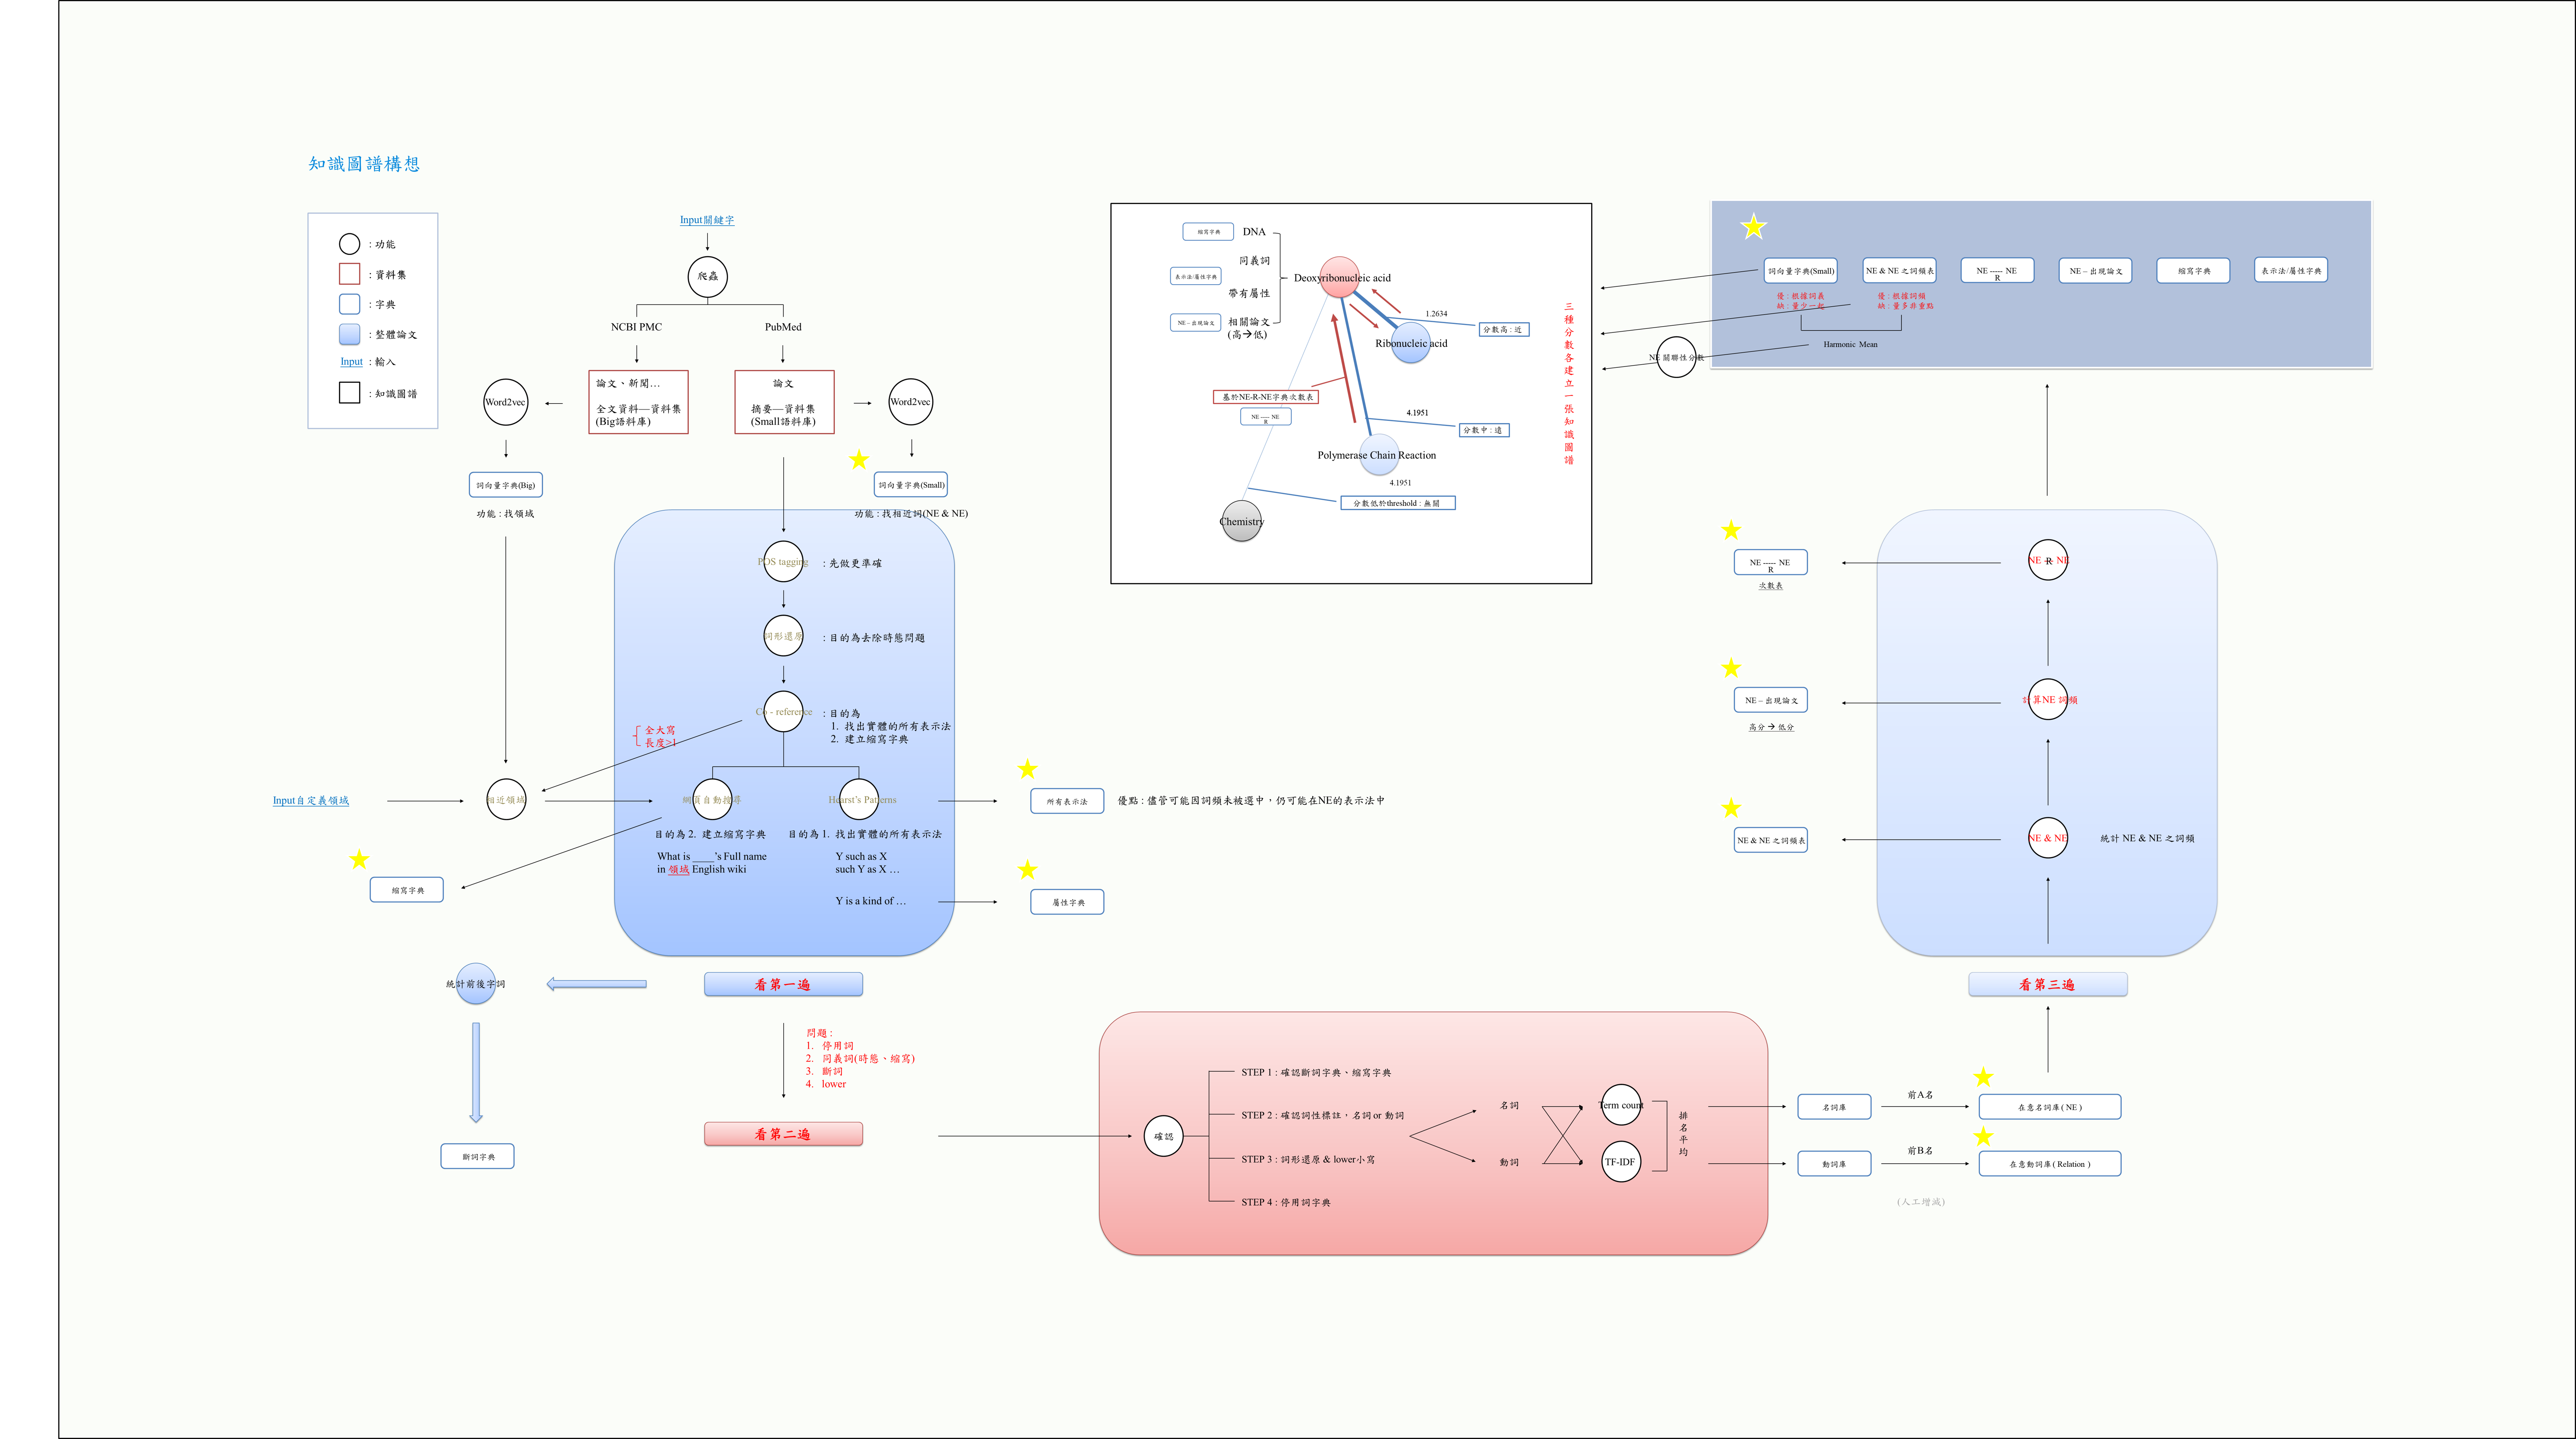

In [350]:
from IPython.display import Image
Image(filename = '知識圖譜初步構想.png', width=800, height=500)

## PubMed摘要爬蟲

In [65]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from math import ceil
from pandas import DataFrame
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer # 引入詞形還原
import numpy as np
import time

In [66]:
TOP_path = 'PubMed資料集/'

In [4]:
target = input("關鍵詞")
html = "https://pubmed.ncbi.nlm.nih.gov/?term="
html_paper = "https://pubmed.ncbi.nlm.nih.gov/"

chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)
driver2 = webdriver.Chrome(chrome_options=chrome_options)

button1 = False;button2 = False;button3 = False


mode = ''
if(button1==True):
    mode += '&filter=simsearch1.fha'
if(button2==True):
    mode += '&filter=simsearch2.ffrft'
if(button3==True):
    mode += '&filter=simsearch3.fft'
    
driver.get(html+target+mode)


result = driver.find_element_by_xpath('//*[@id="search-results"]/div[2]/div[1]').text
print(result)

want_papers = int(input('共 '+result+' 個結果，目標前K篇'))
show_times = ceil(want_papers/10)+1

mode += '&page='

ID_result = []
ID_Abstract = []

want_papers_need = want_papers

N_list = []
V_list = []
All_list = []
N_V_list = []

# 開始測量
start = time.time()

for page in range(1,show_times):
    driver.get(html+target+mode+str(page))
    for each_id in range(1,11):
        if(page==1):
            ID_paper = driver.find_element_by_xpath('//*[@id="search-results"]/section/div['+str(page)+']/div/article['+str(each_id)+']/div[2]/div[1]/div[1]/span[5]').text
        else:
            ID_paper = driver.find_element_by_xpath('//*[@id="search-results"]/section/div[2]/div/article['+str(each_id)+']/div[2]/div[1]/div[1]/span[5]').text
        ID_result.append( ID_paper[6:] )
        driver2.get(html_paper+ID_paper[6:]+'/')
        Abstract = driver2.find_element_by_xpath('//*[@id="enc-abstract"]').text
        ID_Abstract.append(Abstract)
        
        with open (TOP_path+'PMID'+ID_paper[6:]+'.txt','a',encoding='utf-8')as file :
            file.write(Abstract)
        
        want_papers_need -= 1
        if(want_papers_need==0):
            break
    if(want_papers_need==0):
            break
# 結束測量
end = time.time()

# 輸出結果
print("執行時間：%f 秒" % (end - start))
print("執行時間：%f 分" % ((end - start)/60))

關鍵詞 PCR virus noninfectious


C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys
C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


244 results


共 244 results 個結果，目標前K篇 244


執行時間：390.053397 秒


## 知識圖譜

In [1]:
from gensim.models import Word2Vec
import nltk
from os import listdir,path,rename,walk,makedirs
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from pandas import DataFrame
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import sleep
import re
import string
import spacy
import numpy as np
import math
# import numpy as np
#from gensim.test.utils import common_texts

In [2]:
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']

def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']

def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return 'n' #defult pos tag

def is_Part_of_speech(tag):
    if tag in ['NN', 'NNS', 'NNP', 'NNPS'] :
        return 'noun'
    
    elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] :
        return 'verb'
    
    elif tag in ['RB', 'RBR', 'RBS'] :
        return 'adverb'
    
    elif tag in ['JJ', 'JJR', 'JJS'] :
        return 'adjective'
    else:
        return 'X'

In [3]:
lemmatizer = WordNetLemmatizer()

In [4]:
save_path = 'Word2vec/'
stop_word_path = 'Word2vec/'
target_path = 'PubMed資料集/'

In [5]:
#載入停用詞
stop_word = []
with open(stop_word_path+'英文停用詞.txt','r',encoding='utf-8') as file :
    for i in file:
        stop_word.append(i.split()[0])
        
stop_word_n = []
with open(stop_word_path+'英文停用詞_n.txt','r',encoding='utf-8') as file_n :
    for i in file_n:
        stop_word_n.append(i.split()[0])
        
stop_word_v = []
with open(stop_word_path+'英文停用詞_v.txt','r',encoding='utf-8') as file_v :
    for i in file_v:
        stop_word_v.append(i.split()[0])

In [6]:
def replace_word(txt):
    txt = txt.replace('\ufeff','')
    txt = txt.replace('-------------------------------','')
    for ch in '!"#$&()*+,/:;<=>?@[\\]^{|}·~‘’⦁': #-._
        txt = txt.replace(ch,"")
        
    stop_sentence = False
    if len(txt)!= 0 :
        if txt[-1]=='.':
            txt = txt.replace('.',"")
            stop_sentence = True
        
    return txt,stop_sentence

In [7]:
class HearstPatterns(object):

    def __init__(self, extended=False):

        self.__adj_stopwords = [
            'able', 'available', 'brief', 'certain',
            'different', 'due', 'enough', 'especially', 'few', 'fifth',
            'former', 'his', 'howbeit', 'immediate', 'important', 'inc',
            'its', 'last', 'latter', 'least', 'less', 'likely', 'little',
            'many', 'ml', 'more', 'most', 'much', 'my', 'necessary',
            'new', 'next', 'non', 'old', 'other', 'our', 'ours', 'own',
            'particular', 'past', 'possible', 'present', 'proud', 'recent',
            'same', 'several', 'significant', 'similar', 'such', 'sup', 'sure'
        ]

        # now define the Hearst patterns
        # format is <hearst-pattern>, <general-term>
        # so, what this means is that if you apply the first pattern,
        # the first Noun Phrase (NP)
        # is the general one, and the rest are specific NPs
        self.__hearst_patterns = [
            (
                '(NP_\\w+ (, )?such as (NP_\\w+ ?(, )?(and |or )?)+)',
                'first'
            ),
            (
                '(such NP_\\w+ (, )?as (NP_\\w+ ?(, )?(and |or )?)+)',
                'first'
            ),
            (
                '((NP_\\w+ ?(, )?)+(and |or )?other NP_\\w+)',
                'last'
            ),
            (
                '(NP_\\w+ (, )?include (NP_\\w+ ?(, )?(and |or )?)+)',
                'first'
            ),
            (
                '(NP_\\w+ (, )?especially (NP_\\w+ ?(, )?(and |or )?)+)',
                'first'
            ),
        ]

        if extended:
            self.__hearst_patterns.extend([
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?any other NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?some other NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?be a NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?like (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    'such (NP_\\w+ (, )?as (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?like other NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?one of the NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?one of these NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?one of those NP_\\w+)',
                    'last'
                ),
                (
                    'example of (NP_\\w+ (, )?be (NP_\\w+ ? '
                    '(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?be example of NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?for example (, )?'
                    '(NP_\\w+ ?(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?which be call NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?which be name NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?mainly (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?mostly (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?notably (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?particularly (NP_\\w+ ? '
                    '(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?principally (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?in particular (NP_\\w+ ? '
                    '(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?except (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?other than (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?e.g. (, )?(NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ \\( (e.g.|i.e.) (, )?(NP_\\w+ ? (, )?(and |or )?)+'
                    '(\\. )?\\))',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?i.e. (, )?(NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and|or)? a kind of NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and|or)? kind of NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and|or)? form of NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?which look like NP_\\w+)',
                    'last'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?which sound like NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?which be similar to (NP_\\w+ ? '
                    '(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?example of this be (NP_\\w+ ? '
                    '(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?type (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )? NP_\\w+ type)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?whether (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(compare (NP_\\w+ ?(, )?)+(and |or )?with NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?compare to (NP_\\w+ ? (, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '(NP_\\w+ (, )?among -PRON- (NP_\\w+ ? '
                    '(, )?(and |or )?)+)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and |or )?as NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )? (NP_\\w+ ? (, )?(and |or )?)+ '
                    'for instance)',
                    'first'
                ),
                (
                    '((NP_\\w+ ?(, )?)+(and|or)? sort of NP_\\w+)',
                    'last'
                ),
                (
                    '(NP_\\w+ (, )?which may include (NP_\\w+ '
                    '?(, )?(and |or )?)+)',
                    'first'
                )
            ])

        self.__spacy_nlp = spacy.load('en_core_web_sm')

    def chunk(self, rawtext):
        doc = self.__spacy_nlp(rawtext)
        chunks = []
        for sentence in doc.sents:
            sentence_text = sentence.lemma_
            for chunk in sentence.noun_chunks:
                if chunk.lemma_.lower() == "example":
                    start = chunk.start
                    pre_token = sentence[start - 1].lemma_.lower()
                    post_token = sentence[start + 1].lemma_.lower()
                    if start > 0 and\
                            (pre_token == "for" or post_token == "of"):
                        continue
                if chunk.lemma_.lower() == "type":
                    continue
                chunk_arr = []
                replace_arr = []
                # print("chunk:", chunk)
                for token in chunk:
                    if token.lemma_ in self.__adj_stopwords + ["i.e.", "e.g."]:
                        continue
                    chunk_arr.append(token.lemma_)
                    # Remove punctuation and stopword adjectives
                    # (generally quantifiers of plurals)
                    if token.lemma_.isalnum():
                        replace_arr.append(token.lemma_)
                    else:
                        replace_arr.append(''.join(
                            char for char in token.lemma_ if char.isalnum()
                        ))
                if len(chunk_arr) == 0:
                    chunk_arr.append(chunk[-1].lemma_)
                chunk_lemma = ' '.join(chunk_arr)
                # print(chunk_lemma)
                replacement_value = 'NP_' + '_'.join(replace_arr)
                if chunk_lemma:
                    sentence_text = re.sub(r'\b%s\b' % re.escape(chunk_lemma),
                                           r'%s' % replacement_value,
                                           sentence_text)
            chunks.append(sentence_text)
        return chunks

    """
        This is the main entry point for this code.
        It takes as input the rawtext to process and returns a list
        of tuples (specific-term, general-term)
        where each tuple represents a hypernym pair.
    """
    def find_hyponyms(self, rawtext):

        hyponyms = []
        np_tagged_sentences = self.chunk(rawtext)

        for sentence in np_tagged_sentences:
            # two or more NPs next to each other should be merged
            # into a single NP, it's a chunk error

            for (hearst_pattern, parser) in self.__hearst_patterns:
                matches = re.search(hearst_pattern, sentence)
                if matches:
                    match_str = matches.group(0)

                    nps = [a for a in match_str.split() if a.startswith("NP_")]

                    if parser == "first":
                        general = nps[0]
                        specifics = nps[1:]
                    else:
                        general = nps[-1]
                        specifics = nps[:-1]

                    for i in range(len(specifics)):
                        pair = (
                            self.clean_hyponym_term(specifics[i]),
                            self.clean_hyponym_term(general)
                        )
                        # reduce duplicates
                        if pair not in hyponyms:
                            hyponyms.append(pair)

        return hyponyms

    def clean_hyponym_term(self, term):
        # good point to do the stemming or lemmatization
        return term.replace("NP_", "").replace("_", " ")

In [8]:
h = HearstPatterns(extended = True)

In [9]:
def tokenize_English(each_sentence,Near_word_title,Near_word,near_range):
    Near_split = each_sentence.split()
    Near_split2 = Near_split[:-1]
    new_word = replace_word(Near_split[-1])[0]
    if(new_word!=''):
        Near_split2.append(new_word)
    Near_split = Near_split2  
    sentence_long = len(Near_split)
    for run_near_word in range(sentence_long):
        #若第一次當開頭
        if(Near_split[run_near_word] not in Near_word_title):
            Near_word_title.append(Near_split[run_near_word])
            Near_word.append([[Near_split[run_near_word]],[1]])
            if(sentence_long-(run_near_word+1)>(near_range-1)):
                for near_words in range(near_range):
                    str_near_word = ''
                    for add_near_word in range(run_near_word,run_near_word+(near_words+1)+1):
                        if(add_near_word!=run_near_word+(near_words+1)):
                            str_near_word += Near_split[add_near_word] + ' '
                        else:
                            str_near_word += Near_split[add_near_word]
                    Near_word[-1][0].append(str_near_word)
                    Near_word[-1][1].append(1)
            else:
                str_near_word = Near_split[run_near_word] + ' '
                for near_words in range(run_near_word+1,sentence_long):
                    if((near_words+1)!=sentence_long):
                        str_near_word += Near_split[near_words]
                        Near_word[-1][0].append(str_near_word)
                        Near_word[-1][1].append(1)
                        str_near_word += ' '
                    else:
                        str_near_word += Near_split[near_words]
                        Near_word[-1][0].append(str_near_word)
                        Near_word[-1][1].append(1)

        #若非第一次當開頭
        else :
            Near_word_position = Near_word_title.index(Near_split[run_near_word])
            Near_word[Near_word_position][1][0] += 1
            if(sentence_long-(run_near_word+1)>(near_range-1)):
                for near_words in range(near_range):
                    str_near_word = ''
                    for add_near_word in range(run_near_word,run_near_word+(near_words+1)+1):
                        if(add_near_word!=run_near_word+(near_words+1)):
                            str_near_word += Near_split[add_near_word] + ' '
                        else:
                            str_near_word += Near_split[add_near_word]
                    if(str_near_word not in Near_word[Near_word_position][0]):
                        Near_word[Near_word_position][0].append(str_near_word)
                        Near_word[Near_word_position][1].append(1)
                    else:
                        position_in_apper_list = Near_word[Near_word_position][0].index(str_near_word)
                        Near_word[Near_word_position][1][position_in_apper_list] += 1
            else:
                str_near_word = Near_split[run_near_word] + ' '
                for near_words in range(run_near_word+1,sentence_long):
                    if((near_words+1)!=sentence_long):
                        str_near_word += Near_split[near_words]
                        if(str_near_word not in Near_word[Near_word_position][0]):
                            Near_word[Near_word_position][0].append(str_near_word)
                            Near_word[Near_word_position][1].append(1)
                        else:
                            position_in_apper_list = Near_word[Near_word_position][0].index(str_near_word)
                            Near_word[Near_word_position][1][position_in_apper_list] += 1
                        str_near_word += ' '
                    else:
                        str_near_word += Near_split[near_words]
                        if(str_near_word not in Near_word[Near_word_position][0]):
                            Near_word[Near_word_position][0].append(str_near_word)
                            Near_word[Near_word_position][1].append(1)
                        else:
                            position_in_apper_list = Near_word[Near_word_position][0].index(str_near_word)
                            Near_word[Near_word_position][1][position_in_apper_list] += 1     
    return Near_word_title,Near_word

In [10]:
Attributes=[
'is known as',
'is composed of',
'is a kind of',
'is a',
'is',
'are known as',
'are composed of',
'are a kind of',
'are',
'called',
'belong'
'is belong',
'isolated from',
'isolates',
'was known as',
'was composed of',
'was a kind of',
'was a',
'was',
'were known as',
'were composed of',
'were a kind of',
'were',
'used for'
]

In [11]:
def google_search(word_a,Domain,open_or_not = False):

    try:
        driver.get("https://www.google.com/search?q=what is the full name of "+word_a+" in the "+Domain+" field")
        Abstract_wiki = driver.find_element_by_xpath('//*[@id="rso"]/div[1]/div[1]/div/div[1]/div').text
        
        if(open_or_not):
            print(Abstract_wiki)
            print('-----------')
        if(Abstract_wiki[:6] != '翻譯這個網頁'):
            chinese = Abstract_wiki.find('網路上的精選摘要')
            chinese2 = Abstract_wiki.find('全部顯示')
            if(chinese!=-1 and chinese2!=-1):
                if(open_or_not):
                    print('網路上的精選摘要&全部顯示')
                if(Abstract_wiki.find(' ('+word_a+')')!=-1):
                    sentence_abbreviation = Abstract_wiki[14:Abstract_wiki.find(' ('+word_a+')')]
                else:
                    if(Abstract_wiki.find(word_a+' (')!=-1):
                        start_position = Abstract_wiki.find(word_a+' (')+len(word_a)+2
                        end_position = Abstract_wiki[start_position:].find(')')
                        sentence_abbreviation = Abstract_wiki[start_position:start_position+end_position]
                        if(open_or_not):
                            print(sentence_abbreviation)
                    else:
                        sentence_abbreviation = Abstract_wiki[14:Abstract_wiki.find(' ('+word_a+')')]
            elif(chinese!=-1):
                if(open_or_not):
                    print('網路上的精選摘要')
                if(Abstract_wiki.find(' ('+word_a+')')!=-1):
                    sentence_abbreviation = Abstract_wiki[9:Abstract_wiki.find(' ('+word_a+')')]
                else:
                    if(Abstract_wiki.find(word_a+' (')!=-1):
                        start_position = Abstract_wiki.find(word_a+' (')+len(word_a)+2
                        end_position = Abstract_wiki[start_position:].find(')')
                        sentence_abbreviation = Abstract_wiki[start_position:start_position+end_position]
                        if(open_or_not):
                            print(sentence_abbreviation)
                    else:
                        sentence_abbreviation = Abstract_wiki[9:Abstract_wiki.find(' ('+word_a+')')]
            elif(chinese2!=-1):
                if(open_or_not):
                    print('全部顯示')
                if(Abstract_wiki.find(' ('+word_a+')')!=-1):
                    sentence_abbreviation = Abstract_wiki[5:Abstract_wiki.find(' ('+word_a+')')]
                else:
                    if(Abstract_wiki.find(word_a+' (')!=-1):
                        start_position = Abstract_wiki.find(word_a+' (')+len(word_a)+2
                        end_position = Abstract_wiki[start_position:].find(')')
                        sentence_abbreviation = Abstract_wiki[start_position:start_position+end_position]
                        if(open_or_not):
                            print(sentence_abbreviation)
                    else:
                        sentence_abbreviation = Abstract_wiki[5:Abstract_wiki.find(' ('+word_a+')')]
            else:
                if(Abstract_wiki.find(' ('+word_a+')')!=-1):
                    sentence_abbreviation = Abstract_wiki[:Abstract_wiki.find(' ('+word_a+')')]
                else:
                    if(Abstract_wiki.find(word_a+' (')!=-1):
                        start_position = Abstract_wiki.find(word_a+' (')+len(word_a)+2
                        end_position = Abstract_wiki[start_position:].find(')')
                        sentence_abbreviation = Abstract_wiki[start_position:start_position+end_position]
                        if(open_or_not):
                            print(sentence_abbreviation)
                    else:
                        sentence_abbreviation = Abstract_wiki[:Abstract_wiki.find(' ('+word_a+')')]


            if ( sentence_abbreviation.find('\n') != -1 ):
            #     print(sentence_abbreviation.find('\n'))
                if(open_or_not):
                    print('有換行')
                sentence_abbreviation = sentence_abbreviation[:sentence_abbreviation.find('\n')]
                if(open_or_not):
                    print('-----------')
                    print(sentence_abbreviation)
            else:
                if(open_or_not):
                    print('-----------')
                    print(sentence_abbreviation)
        else:
            sentence_abbreviation = ''

        return sentence_abbreviation
    except:
        return ''

In [12]:
def google_search_Attributes(word_a,open_or_not = False):
    driver.get("https://en.wikipedia.org/wiki/"+word_a)
    str_google_search_Attributes = ''
    for i in range(1,4):
        Introduction = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div[1]/p['+str(i)+']').text
#         print(Introduction)
        str_google_search_Attributes += Introduction+'\n'
#     driver.find_element_by_xpath("//div[@id='rso']/div/div/div/div/a/h3/span").click()
    return str_google_search_Attributes

In [13]:
def find_brackets(str_paper,not_abbreviation,all_index,all_pass_index,all_q_index):
    word_a = '\(' 
    a = [m.start() for m in re.finditer(word_a, str_paper)] 
    word_b = '\)' 
    b = [m.start() for m in re.finditer(word_b, str_paper)] 



    if (len(a)==len(b)):
        for show_index in range(len(a)):
            raw_word = str_paper[a[show_index]:b[show_index]+1]
            word = str_paper[a[show_index]+1:b[show_index]]
            if word not in not_abbreviation :
                sentence_long = str_paper[:a[show_index]]
                end_position = sentence_long.rfind('. ')
                if(end_position!=-1):
                    sentence = sentence_long[end_position+2:]
                else:
                    sentence = sentence_long
                sentence_word_list = sentence.split()
                sentence_word_list_r = sentence_word_list[::-1]

        #         print(sentence)

                str_get_word = ''
                find_position = -1
                for each_word in range(len(sentence_word_list_r)) :
                    if(sentence_word_list_r[each_word][0]==word[0].upper()):
                        find_position = each_word
                        break

                if(find_position != -1):
                    for add_word_get in sentence_word_list[(len(sentence_word_list_r)-1)-find_position:] :
                        str_get_word += add_word_get + ' '
                    str_get_word = str_get_word[:-1]


                str_get_word2 = ''
                find_position = -1
                for each_word in range(len(sentence_word_list_r)) :
                    if(sentence_word_list_r[each_word][0]==word[0].lower()):
                        find_position = each_word
                        break
                if(find_position != -1):
                    for add_word_get in sentence_word_list[(len(sentence_word_list_r)-1)-find_position:] :
                        str_get_word2 += add_word_get + ' '
                    str_get_word2 = str_get_word2[:-1]   
                if(len(str_get_word2)<len(str_get_word) or str_get_word == ''):
                    if(str_get_word2!= ''):
                        str_get_word = str_get_word2

                if not word.isdigit() :
                    if len(word.split())==1 :
    #                     print (word)
                        if(str_get_word!=''):
#                             print(str_get_word)
                            all_pass_index.append([word,str_get_word])
                        else:
    #                         print('?')
                            all_q_index.append([word,str_get_word])
    #                     print()


                all_index.append(word)
    return all_index,all_pass_index,all_q_index

In [14]:
def change_word(text,all_pass_index_Final,all_index,Dictionary_abbreviation,show=False):
    if(show):
        print(text)
        print('-------')
    paper_now = ''
    sentences = nltk.sent_tokenize(text)

    for each_sentence in sentences :

        each_word_first_change = each_sentence.split()

        for word_change in each_word_first_change:
            new_word_change,word_change_end = replace_word(word_change)
            if(new_word_change not in all_index and new_word_change not in Dictionary_abbreviation):
                paper_now += new_word_change.lower()+' '
            else:
                paper_now += new_word_change+' '
            if(word_change_end):
                paper_now += '. '

    paper_now2 = paper_now
    paper_now2_show = paper_now
    new_paper_now = paper_now
    new_paper_now_show = paper_now
    for each_pass in all_pass_index_Final :
        for each_pass_index in each_pass[1]:

            www = ' '+each_pass_index+' '

            while(paper_now2.find(www)!=-1):

                pass_postion = paper_now2.find(www)
                if(pass_postion != -1):
                    new_paper_now = paper_now2[:pass_postion]
                    new_paper_now += ' '+each_pass[0]+' '
                    new_paper_now += paper_now2[pass_postion+len(www):]
                    if(show):
                        print(each_pass_index,'-->',each_pass[0])
                    paper_now2 = new_paper_now
                if(show):
                    pass_postion_show = paper_now2_show.find(www)
                    if(pass_postion_show != -1):
                        new_paper_now_show = paper_now2_show[:pass_postion_show]
                        new_paper_now_show += ' \033[1;32;43m'+each_pass[0]+'\033[0m '
                        new_paper_now_show += paper_now2_show[pass_postion_show+len(www):]

                        paper_now2_show = new_paper_now_show
    if(show):
        print('-------')
        print(new_paper_now_show)  
    if(show==False):
        return new_paper_now

In [15]:
def sort(appear_word_n,term_count_n,term_frequency_n,TF_IDF_add_n):

    appear_word_term_count_n = appear_word_n

    list_term_count_score_n , list_term_count_word_n = (list(t) for t in zip(*sorted(zip(term_count_n,appear_word_term_count_n))))
    list_term_count_score_n = list_term_count_score_n[::-1]
    list_term_count_word_n = list_term_count_word_n[::-1]

    appear_word_TF_IDF_add_n = appear_word_n

    list_TF_IDF_add_score_n , list_TF_IDF_add_word_n = (list(t) for t in zip(*sorted(zip(TF_IDF_add_n,appear_word_TF_IDF_add_n))))
    list_TF_IDF_add_score_n = list_TF_IDF_add_score_n[::-1]
    list_TF_IDF_add_word_n = list_TF_IDF_add_word_n[::-1]
    
    appear_word_term_frequency_n = appear_word_n

    list_term_frequency_score_n , list_term_frequency_word_n = (list(t) for t in zip(*sorted(zip(term_frequency_n,appear_word_term_frequency_n))))
    list_term_frequency_score_n = list_term_frequency_score_n[::-1]
    list_term_frequency_word_n = list_term_frequency_word_n[::-1]
    
    return list_term_count_word_n,list_term_count_score_n,list_term_frequency_word_n,list_term_frequency_score_n,list_TF_IDF_add_word_n,list_TF_IDF_add_score_n

In [16]:
def mix_sorting(appear_word_n,list_term_count_word_n,list_term_frequency_word_n,list_TF_IDF_add_word_n):
    mix_sort_appear_word_n = appear_word_n
    mix_sort = []
    for i in appear_word_n :
        sort_1 = int(list_term_count_word_n.index(i))
        sort_2 = int(list_term_frequency_word_n.index(i))
        sort_3 = int(list_TF_IDF_add_word_n.index(i))
        mix_sort.append(int((sort_1+sort_2+sort_3)/3))
    mix_sort_score_n , mix_sort_word_n = (list(t) for t in zip(*sorted(zip(mix_sort,mix_sort_appear_word_n))))
    return mix_sort_word_n,mix_sort_score_n

In [17]:
def term_count(new_papers_2,stop_word,stop_word_type,type_):
    appear_word = []
    term_count = []
    appear_word_papers = []

    paper_id = 0
    for now_paper in new_papers_2:

        sentences = nltk.sent_tokenize(now_paper)
        for each_sentence in sentences :
            # POS Tagging -(1)
            each_sentence_list = each_sentence.split()
            tagged = pos_tag(each_sentence_list)
            for word_, pos in tagged:

                #####
                # POS Tagging -(2)簡單化 4 Type 
                Part_of_speech = is_Part_of_speech(pos)
                #####
    #             print(word_,Part_of_speech)
    #             print(Part_of_speech)
                if(Part_of_speech == type_ and word_ not in stop_word and word_ not in stop_word_type and len(word_)>1):

                    if(word_ not in appear_word):
                        appear_word.append(word_)
                        term_count.append(1)
                        appear_word_papers.append([paper_id])
                    else:
                        word_position = appear_word.index(word_)
                        term_count[word_position] += 1
                        if paper_id not in appear_word_papers[word_position] :
                            appear_word_papers[word_position].append(paper_id)
        paper_id += 1
        
    return appear_word,term_count,appear_word_papers

## 看第一遍

In [18]:
target_path = 'STEP3     colorectal cancer and bacteria_pass_include_bacteria/'

In [19]:
word2vec_trainning_texts = []
word2vec_trainning_texts_n = []
word2vec_trainning_texts_v = []
word2vec_trainning_texts_4type = []

word_texts_n = []
word_texts_v = []

paper_num = 0

raw_papers = []
new_papers = []

Dictionary_HearstPatterns_word = []
Dictionary_HearstPatterns_time = []

Dictionary_abbreviation = []

Near_word_title = []
Near_word = []
near_range = 2

all_index = []
all_pass_index = []
all_q_index = []


not_abbreviation = ['I','II','III','IV','V','VI','VII','VIII','VV','i','ii','iii','iv','v','vi','vii','viii','vv']

paper_name = []

for root, dirs, files in walk(target_path):
    for each_paper in files :
#         print(each_paper)
        paper_name.append(each_paper)
        paper_now = ''
        with open(target_path+each_paper,'r',encoding='utf-8') as file :
            text = file.read()
            raw_papers.append(text)
            sentences = nltk.sent_tokenize(text)
            
            ####
            #尋找括號前面的全文
            all_index,all_pass_index,all_q_index = find_brackets(text,not_abbreviation,all_index,all_pass_index,all_q_index)
            ####
            
            for each_sentence in sentences :
                
#                 #####
#                 #統計斷詞頻率
#                 Near_word_title,Near_word = tokenize_English(each_sentence,Near_word_title,Near_word,near_range)      
#                 #####
                
                #####
                #尋找符合HearstPatterns之關係
                Dictionary_HearstPatterns = h.find_hyponyms(each_sentence)
                for each_same in Dictionary_HearstPatterns :
                    if each_same in Dictionary_HearstPatterns_word :
                        position = Dictionary_HearstPatterns_word.index(each_same)
                        Dictionary_HearstPatterns_time[position] += 1
                    else:
                        Dictionary_HearstPatterns_word.append(each_same)
                        Dictionary_HearstPatterns_time.append(1)      
                #####
                
                pass_sentence = []
                pass_sentence_n = []
                pass_sentence_v = []
                pass_sentence_4type = []
                each_sentence_list = each_sentence.split()
                
                # POS Tagging -(1)
                tagged = pos_tag(each_sentence_list)
                for each_word, pos in tagged:
                    
                    #####
                    # POS Tagging -(2)簡單化 4 Type 
                    Part_of_speech = is_Part_of_speech(pos)
                    #####
                    
                    # 詞形還原 -(1)
                    input_Attributes = penn_to_wn(pos)
                    
                    #####
                    # 過濾成新的 Papers
                    # 收集word2vec用的 4 Type 庫
                    if(Part_of_speech != 'X'): #唯有 4 Type才做
                        # 詞形還原 -(2)還原
                        Reduction = lemmatizer.lemmatize(each_word,pos=input_Attributes)
                        new_word,end = replace_word(Reduction)
                        if(new_word != ''):
                            if(new_word.isupper() and len(new_word)>1):
                                pass_sentence_4type.append(new_word)
                                paper_now += new_word +' ' # 如果是縮寫就不動
                            else:
                                if(new_word.lower() not in stop_word ):
                                    pass_sentence_4type.append(new_word.lower())
                                    paper_now += new_word.lower() +' ' 
                            if(end):
                                paper_now += '. '
                    #####
                    
                    #####
                    # 收集word2vec用的 名詞庫、動詞庫、名動詞庫
                    if(Part_of_speech == 'noun' or Part_of_speech == 'verb'): #唯有 N / V才做 # if(1):
                        Reduction = lemmatizer.lemmatize(each_word,pos=input_Attributes)  
                        new_word,end = replace_word(Reduction)
                        if(new_word != ''):
                            # ~~~如果是縮寫~~~
                            if(new_word.isupper() and len(new_word)>1 and new_word not in not_abbreviation):
                                pass_sentence.append(new_word)
                                if(new_word not in Dictionary_abbreviation) :
                                    Dictionary_abbreviation.append(new_word)
                                if(Part_of_speech == 'noun'):
                                    pass_sentence_n.append(new_word)
                                    if new_word not in word_texts_n:
                                        word_texts_n.append(new_word)
                                elif(Part_of_speech == 'verb'):
                                    pass_sentence_v.append(new_word)
                                    if new_word not in word_texts_v:
                                        word_texts_v.append(new_word)
                                ###
                                
                                ###
                            else:
                                if(new_word.lower() not in stop_word ):
                                    pass_sentence.append(new_word.lower())
                                    if(Part_of_speech == 'noun'):
                                        pass_sentence_n.append(new_word.lower())
                                        if new_word.lower() not in word_texts_n:
                                            word_texts_n.append(new_word.lower())
                                    elif(Part_of_speech == 'verb'):
                                        pass_sentence_v.append(new_word.lower())
                                        if new_word.lower() not in word_texts_v:
                                            word_texts_v.append(new_word.lower())
                    #####
                    
                ##### 收集word2vec用
                if(pass_sentence_4type!=[]):
                    word2vec_trainning_texts_4type.append(pass_sentence_4type)
                if(pass_sentence!=[]):
                    word2vec_trainning_texts.append(pass_sentence)
                if(pass_sentence_n!=[]):
                    word2vec_trainning_texts_n.append(pass_sentence_n)
                if(pass_sentence_v!=[]):
                    word2vec_trainning_texts_v.append(pass_sentence_v)
            #####
            #統計斷詞頻率
            Near_word_title,Near_word = tokenize_English(paper_now,Near_word_title,Near_word,near_range)      
            #####    
                
            ##### 過濾成新的 Papers
            new_papers.append(paper_now) 
            
            paper_num += 1
print('執行完'+str(paper_num)+'篇PubMed論文摘要')

執行完125篇PubMed論文摘要


## 產生內容檢查

## 斷詞字典

In [20]:
Near_word_final = []
for sorting in range(len(Near_word)):
    list1 , list2 = (list(t) for t in zip(*sorted(zip(Near_word[sorting][1],Near_word[sorting][0]))))
    list1 = list1[::-1]
    list2 = list2[::-1]
    Near_word_final.append([list2,list1])

In [50]:
299/435

0.6873563218390805

In [56]:
9/24

0.375

In [69]:
ID = Near_word_title.index('streptococcus') #polymerase #deoxyribonucleic #propidium monoazide
threshold_tokenize = 0.3
for showwing in range(len(Near_word_final[ID][1])):
    try:
        tokenize_yes_no_number = Near_word_final[ID][1][showwing]/Near_word[ID][1][0] #用原始單獨自己來算
        if(tokenize_yes_no_number>=threshold_tokenize):
            print(Near_word_final[ID][0][showwing],Near_word_final[ID][1][showwing],' True ')
        else:
            print(Near_word_final[ID][0][showwing],Near_word_final[ID][1][showwing],' False ')
    except:
        print('...')

streptococcus 24  True 
streptococcus gallolyticus 9  True 
streptococcus bovis 3  False 
streptococcus gallolyticus subspecies 2  False 
streptococcus gallolyticus enterococcus 2  False 
streptococcus vestibularis flavonifractor 1  False 
streptococcus vestibularis 1  False 
streptococcus sp . 1  False 
streptococcus sp 1  False 
streptococcus solobacterium streptococcus 1  False 
streptococcus solobacterium 1  False 
streptococcus peptostreptococcus significantly 1  False 
streptococcus peptostreptococcus 1  False 
streptococcus luteciae lactobacillus 1  False 
streptococcus luteciae 1  False 
streptococcus infection colorectal 1  False 
streptococcus infection 1  False 
streptococcus infantarius subsp 1  False 
streptococcus infantarius 1  False 
streptococcus helicobacter pylori 1  False 
streptococcus helicobacter 1  False 
streptococcus gallolyticus subsp 1  False 
streptococcus gallolyticus sg 1  False 
streptococcus gallolyticus member 1  False 
streptococcus gallolyticus HR 1 

In [25]:
Near_word[ID][0][0]

'colorectal'

In [26]:
Near_word_final[ID][1][showwing]

1

In [58]:
Dictionary_tokenize_final = []
Dictionary_tokenize_final_score = []

for Near_word_title_each in Near_word_title:
    ID = Near_word_title.index(Near_word_title_each) #polymerase #deoxyribonucleic #propidium monoazide
    threshold_tokenize = 0.3
    threshold_time = 5
    for showwing in range(len(Near_word_final[ID][1])):
        try:
            if(Near_word[ID][1][0] >= threshold_time):
                tokenize_yes_no_number = Near_word_final[ID][1][showwing]/Near_word[ID][1][0] #用原始單獨自己來算
                if(tokenize_yes_no_number>=threshold_tokenize):
                    if(len(Near_word_final[ID][0][showwing].split())>1):
                        if ' .' not in Near_word_final[ID][0][showwing] :
                            Dictionary_tokenize_final.append(Near_word_final[ID][0][showwing])
                            Dictionary_tokenize_final_score.append([Near_word_final[ID][0][showwing],tokenize_yes_no_number])
    #                 print(Near_word_final[ID][0][showwing],Near_word_final[ID][1][showwing],' True ')
    #             else:
    #                 print(Near_word_final[ID][0][showwing],Near_word_final[ID][1][showwing],' False ')
        except:
            print('...')

In [59]:
Dictionary_tokenize = DataFrame(Dictionary_tokenize_final_score,columns=['tokenize','score'])
Dictionary_tokenize

,tokenize,score
0,symbiotic relationship,0.428571
1,protection assay,0.600000
2,colon cancer,0.355556
3,fusobacterium nucleatum,0.554545
4,porphyromonas spp,0.375000
...,...,...
255,leakage resection,0.333333
256,CEACAM proteins,0.500000
257,TGFB signal,0.600000
258,vitamin supplementation,0.300000


In [60]:
Dictionary_tokenize.to_csv('data.csv')

## Word2vec

#### 訓練模型

In [29]:
print('包含4種type句子 : ',len(word2vec_trainning_texts_4type))
print('包含名詞動詞句子 : ',len(word2vec_trainning_texts))
print('名詞句子 : ',len(word2vec_trainning_texts_n))
print('動詞句子 : ',len(word2vec_trainning_texts_v))

包含4種type句子 :  1226
包含名詞動詞句子 :  1226
名詞句子 :  1226
動詞句子 :  1075


In [30]:
print('看到名詞(不重複)出現字數 : ',len(word_texts_n))
print('看到動詞(不重複)出現字數 : ',len(word_texts_v))

看到名詞(不重複)出現字數 :  2066
看到動詞(不重複)出現字數 :  618


In [31]:
model = Word2Vec(sentences=word2vec_trainning_texts_4type, window=5, min_count=1, workers=4) #, vector_size=100
model.save(save_path+"word2vec.model")

#### 提出訓練好的model

In [32]:
model = Word2Vec.load(save_path+"word2vec.model")

In [33]:
print('一個字用幾維vector表示 : '+str(model.vector_size))

一個字用幾維vector表示 : 100


In [34]:
vocab_list = list(model.wv.vocab.keys())
print('word2vec 字數 : '+str(len(vocab_list)))
print('實例 : ')
for i in vocab_list[:5]:
    print(i)

word2vec 字數 : 3343
實例 : 
human
organism
coexists
microbiota
symbiotic


In [35]:
ans = model.wv.most_similar(positive=['PCR'], negative=[], topn=10)
# ans = model.wv.most_similar(positive=['virus','PCR'], negative=[], topn=10)
# ans = model.wv.most_similar(positive=['virus'], negative=['PCR'], topn=10)
for i in ans :
    print(i)

('colorectal', 0.9522329568862915)
('CRC', 0.9517570734024048)
('patient', 0.9513689279556274)
('tissue', 0.9511973857879639)
('cancer', 0.9508193135261536)
('protein', 0.9487596750259399)
('role', 0.9481932520866394)
('development', 0.9476990699768066)
('level', 0.9466919898986816)
('compare', 0.9466749429702759)


In [36]:
word_a = 'virus'
word_b = 'PCR'

two_word_distance = model.wv.distance(word_a,word_b)
print(word_a+' & '+word_b+'距離 : ')
print(two_word_distance)

virus & PCR距離 : 
0.20568609237670898


In [37]:
vector = model.wv.get_vector('virus')
print(vector)

[-0.00249906 -0.00036284 -0.00513586  0.01132231  0.00050149 -0.00114625
  0.00886117 -0.0023184  -0.0038136  -0.00330997  0.00499808  0.00427683
 -0.00134858  0.00242079 -0.00161163 -0.00828812 -0.00251377  0.00280613
  0.00484041 -0.0035387   0.00561339  0.00774198 -0.00492098 -0.0079431
 -0.00735871 -0.00277423  0.00621336 -0.0055018   0.00097768 -0.0004051
 -0.00667449  0.00749021 -0.00041879  0.01018712 -0.0037436   0.00203373
  0.00432771 -0.00302123 -0.00081501  0.00634119 -0.00129181 -0.0020779
  0.00221436  0.00538881 -0.00130686  0.00442995 -0.00022962 -0.00101307
 -0.00873785 -0.00397918 -0.0003107   0.00199271 -0.00015198  0.00093384
  0.00500088 -0.00141547 -0.00849477  0.00202167  0.00463981 -0.00397588
  0.0055897   0.00023071 -0.00933976 -0.01251694 -0.00466592 -0.00189078
  0.00186968 -0.01058924  0.00424578 -0.0002475  -0.00842714  0.00574882
 -0.00602758 -0.00045102  0.00452948  0.00676975 -0.00511324 -0.0088589
  0.00042458  0.00844124 -0.00741835  0.01002303  0.004

In [38]:
model.wv.similar_by_vector(vector)

[('virus', 1.0),
 ('healthy', 0.8516995906829834),
 ('colorectal', 0.8477561473846436),
 ('nucleatum', 0.8472040891647339),
 ('microbiota', 0.8438863754272461),
 ('identify', 0.8424552083015442),
 ('microbiome', 0.8423523902893066),
 ('study', 0.841508150100708),
 ('suggest', 0.8412914276123047),
 ('normal', 0.8411098122596741)]

#### 用於找領域

In [39]:
all_index[:10]

['CRC',
 'CRC',
 'FFPE',
 'CRC',
 'tumor and paired normal tissue, n = 99',
 'n = 96',
 'n = 104',
 'S. gallolyticus',
 'F. nucleatum',
 'B. fragilis']

In [40]:
all_pass_index[:10]

[['CRC', 'cancer'],
 ['CRC', 'cancer'],
 ['FFPE', 'Formalin-fixed and paraffin-embedded'],
 ['CRC', 'cancer'],
 ['CRC', 'cancer'],
 ['F.n', 'Fusobacterium nucleatum'],
 ['MPE', 'microbiology-molecular pathological epidemiology'],
 ['CRC', 'cancer'],
 ['IBD', 'inflammatory bowel disease'],
 ['CRC', 'cancer']]

In [43]:
all_pass_index_word = []
all_pass_index_Final_times = []

for each_word in all_pass_index :
    if each_word[0] not in all_pass_index_word :
        all_pass_index_Final_times.append([each_word[0],[each_word[1]],[1]])
        all_pass_index_word.append(each_word[0])
    else:
        Index_position = all_pass_index_word.index(each_word[0])
        if(each_word[1] not in all_pass_index_Final_times[Index_position][1]):
            all_pass_index_Final_times[Index_position][1].append(each_word[1])
            all_pass_index_Final_times[Index_position][2].append(1)
        else :
            add_pass_index_times_position = all_pass_index_Final_times[Index_position][1].index(each_word[1])
            all_pass_index_Final_times[Index_position][2][add_pass_index_times_position] += 1

In [44]:
all_pass_index_Final_times[:5]

[['CRC', ['cancer'], [60]],
 ['FFPE', ['Formalin-fixed and paraffin-embedded'], [1]],
 ['F.n', ['Fusobacterium nucleatum'], [1]],
 ['MPE', ['microbiology-molecular pathological epidemiology'], [1]],
 ['IBD',
  ['inflammatory bowel disease',
   'Inflammatory bowel disease',
   'inflammatory bowel diseases'],
  [1, 1, 2]]]

In [46]:
len(all_pass_index_Final_times)

147

In [67]:
all_pass_index_Final = []

for check_appear_times in all_pass_index_Final_times:
    if(len(check_appear_times[0])>1):
        if sum(check_appear_times[2]) >1:
#             print(check_appear_times)
            pass_1 = []
            for check_in_Full_name in check_appear_times[1]:
                Pass_time = 0
                for check_in_Full_name_word in check_appear_times[0] :
                    if(check_in_Full_name_word in [',','-','_',' ']):
                        Pass_time += 1
                    else:
                        if check_in_Full_name_word.lower() in check_in_Full_name.lower() :
                            Pass_time += 1
                if(Pass_time==len(check_appear_times[0]) and check_in_Full_name!=check_appear_times[0]):
                    pass_1.append(check_in_Full_name)
            if(len(pass_1)!=0):
                all_pass_index_Final.append([check_appear_times[0],pass_1])

In [68]:
all_pass_index_Final[:10]

[['CRC', ['cancer']],
 ['IBD',
  ['inflammatory bowel disease',
   'Inflammatory bowel disease',
   'inflammatory bowel diseases']],
 ['OR', ['odds ratio', 'odds ratios']],
 ['P<0.001',
  ['pylori infection was associated with an increased risk of colorectal cancer in the subgroups of Western countries (OR=1.34, 95% CI: 1.14-1.57) (P<0.001), serological testing (OR=1.20, 95% CI: 1.08-1.34) (P=0.001), multiple methods of testing (OR=2.63, 95% CI: 1.09-6.31) (P=0.031), cross-sectional studies (OR=1.92, 95% CI: 1.17-3.16) (P=0.010) and case-control studies (OR 1.26, 95% CI: 1.16-1.36)']],
 ['qPCR',
  ['quantitative polymerase chain reaction',
   'quantitative real time PCR',
   'quantitative PCR',
   'quantitative real-time polymerase chain reaction']],
 ['CRA', ['colorectal adenoma']],
 ['MSI', ['microsatellite instability']],
 ['Fn', ['Fusobacterium nucleatum']],
 ['Hp', ['Helicobacter pylori']],
 ['ETBF', ['Enterotoxigenic Bacteroides fragilis']]]

In [64]:
len(DataFrame(all_pass_index_Final))

22

In [107]:
word_a = 'virus'
word_b = 'acid'

two_word_distance = model.wv.distance(word_a,word_b)
print(word_a+' & '+word_b+'距離 : ')
print(two_word_distance)

virus & acid距離 : 
0.005785226821899414


In [108]:
print('可能之縮寫字 : ',len(Dictionary_abbreviation))

可能之縮寫字 :  521


In [109]:
Dictionary_abbreviation[:10]

['FMDV', 'RNA', 'PCR', 'VP1', 'HERV-K', 'LTR', 'HCV', 'DNA', 'CV-N', 'HIV-1']

In [110]:
want_domain = ['nucleic','PCR','virus'] #,'noninfectious'

In [111]:
word_a = 'DNA'

dis = []
for each_domain in want_domain:
    word_b = each_domain

    two_word_distance = model.wv.distance(word_a,word_b)
    print(word_a+' & '+word_b+'距離 : ')
    print(two_word_distance)
    dis.append(two_word_distance)
    print()

Domain = want_domain[dis.index(min(dis))]

sec_min = 100
sec_min_position = 0

pos = 0
for each_dis in dis :
    if((each_dis-min(dis))!=0 and each_dis<sec_min):
        sec_min = each_dis
        Sec_Domain = want_domain[pos]
    pos += 1

print('搜尋目標 : ', Domain)
print('第二搜尋目標 : ', Sec_Domain)

DNA & nucleic距離 : 
0.008202075958251953

DNA & PCR距離 : 
0.002755105495452881

DNA & virus距離 : 
0.0015149712562561035

搜尋目標 :  virus
第二搜尋目標 :  PCR


In [112]:
chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)
ans = google_search(word_a,Domain) #,True
print(ans)
driver.quit()

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: use options instead of chrome_options
  This is separate from the ipykernel package so we can avoid doing imports until


In [113]:
chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)
ans = google_search(word_a,Sec_Domain) #,True
print(ans)
driver.quit()

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: use options instead of chrome_options
  This is separate from the ipykernel package so we can avoid doing imports until


Polymerase Chain Reaction


In [114]:
chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)
ans = google_search(word_a,'') #,True
print(ans)
driver.quit()

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: use options instead of chrome_options
  This is separate from the ipykernel package so we can avoid doing imports until


Deoxyribonucleic Acid


In [115]:
len(Dictionary_abbreviation)

521

In [116]:
not_in_D = []
in_D = []

for check_D in Dictionary_abbreviation:
    if(check_D not in all_pass_index_word):
        not_in_D.append(check_D)
    else:
        in_D.append(check_D)

In [117]:
print('不在文章前後括號可以搜尋出之懷疑縮寫字詞 : '+str(len(not_in_D)))

不在文章前後括號可以搜尋出之懷疑縮寫字詞 : 302


In [118]:
in_D[:10]

['FMDV', 'RNA', 'PCR', 'LTR', 'HCV', 'CV-N', 'HIV-1', 'SIV', 'HIV', 'RT-PCR']

In [119]:
not_in_D[:10]

['VP1',
 'HERV-K',
 'DNA',
 'HIV-2',
 'HIV-',
 'TCID50',
 'BLV-PCR',
 'PRISM',
 'PE',
 'CA']

In [120]:
Dictionary_abbreviation_web = []
all_pass_index_Final_web = []

chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)

want_domain = ['nucleic','PCR','virus']
Dictionary_abbreviation_final = []

strange_word = '網路上的精選摘要全部顯示翻譯這個網頁'

Target_abbreviation = not_in_D[:10]

num = len(Target_abbreviation)

times = 1
for seach_target in Target_abbreviation :
    
    if(times%10==0):
        driver.quit()
        chrome_options=Options()
        chrome_options.add_argument('--headless')#無介面操作
        driver = webdriver.Chrome(chrome_options=chrome_options)
        
    word_a = seach_target
    print('('+str(num)+')',end=' ')
    if(num%10==0):
        sleep(2)
    dis = []
    for each_domain in want_domain:
        word_b = each_domain
        two_word_distance = model.wv.distance(word_a,word_b)
        dis.append(two_word_distance)

    Domain = want_domain[dis.index(min(dis))] 
    sec_min = 100
    sec_min_position = 0

    pos = 0
    for each_dis in dis :
        if((each_dis-min(dis))!=0 and each_dis<sec_min):
            sec_min = each_dis
            Sec_Domain = want_domain[pos]
        pos += 1

    Full_name_1 = google_search(word_a,Domain)
    Full_name_2 = google_search(word_a,Sec_Domain)
    Full_name_3 = google_search(word_a,'')
    def check_score(word_a,Full_name,strange_word):
        score = 10
        if(Full_name=='' or Full_name=='· 翻譯這個網'):
            score = -100
        for strange in strange_word :
            if(strange in Full_name):
                score = -100
        if(score!=-100):
            if(word_a[0].upper()==Full_name[0].upper()):
                score += 40
                times = 0
                for each_char in word_a :
                    if(each_char.lower() in Full_name.lower()):
                        times+=1
                if(times==len(word_a)):
                    score += 40
                else:
                    score += 20*(times/len(word_a))
            else:
                times = 0
                for each_char in word_a :
                    if(each_char.lower() in Full_name.lower()):
                        times+=1
                if(times==len(word_a)):
                    score += 40
                else:
                    score += 20*(times/len(word_a))
            if(len(Full_name.split())>=10):
                score = -50
                
                str_paper = Full_name

                word_1 = '\(' 
                a = [m.start() for m in re.finditer(word_1, str_paper)] 
                word_2 = '\)' 
                b = [m.start() for m in re.finditer(word_2, str_paper)] 

                if(len(a)>=1):
                    if (len(a)==len(b)):
                        for show_index in range(len(a)):
                            raw_word = str_paper[a[show_index]:b[show_index]+1]
                            word = str_paper[a[show_index]+1:b[show_index]]

                    score2,word2 = check_score(word_a,word,strange_word)
                    if(score2>score):
                        score = score2
                        Full_name = word2
#         print()
#         print(score)
#         print(Full_name)
        return score,Full_name
    
    score_1,Full_name_1 = check_score(word_a,Full_name_1,strange_word)
#     print('---------------------')
    score_2,Full_name_2 = check_score(word_a,Full_name_2,strange_word)
#     print('---------------------')
    score_3,Full_name_3 = check_score(word_a,Full_name_3,strange_word)
    
    list_Full_name = [Full_name_1,Full_name_2,Full_name_3]
    list_compare = [score_1,score_2,score_3]
    if(max(list_compare)<0):
        Full_name = ''
        Dictionary_abbreviation_final.append([word_a,Full_name,'0%信心水準'])
    else:
        Full_name = list_Full_name[list_compare.index(max(list_compare))]
        Dictionary_abbreviation_final.append([word_a,Full_name,str(max(list_compare))+'%信心水準'])
        
        if(max(list_compare)>=50):
            Dictionary_abbreviation_web.append(word_a)
            all_pass_index_Final_web.append([word_a,[Full_name]])
    
    num -= 1
    times += 1

driver.quit()

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


(10) (9) (8) (7) (6) (5) (4) (3) (2) 

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: use options instead of chrome_options


(1) 

In [121]:
Dictionary_abbreviation_final

[['VP1', 'Major capsid protein', '16.666666666666664%信心水準'],
 ['HERV-K', 'Human endogenous retrovirus type K', '66.66666666666667%信心水準'],
 ['DNA', 'Deoxyribonucleic Acid', '90%信心水準'],
 ['HIV-2', 'Human immunodeficiency virus type 2', '66.0%信心水準'],
 ['HIV-', 'human immunodeficiency virus type 1', '65.0%信心水準'],
 ['TCID50', 'tissue culture infectivity dose', '63.33333333333333%信心水準'],
 ['BLV-PCR', 'bovine leukemia virus', '61.42857142857143%信心水準'],
 ['PRISM', '', '0%信心水準'],
 ['PE', 'physical education', '90%信心水準'],
 ['CA', 'Chartered Accountant', '90%信心水準']]

In [122]:
all_pass_index_Final_web

[['HERV-K', ['Human endogenous retrovirus type K']],
 ['DNA', ['Deoxyribonucleic Acid']],
 ['HIV-2', ['Human immunodeficiency virus type 2']],
 ['HIV-', ['human immunodeficiency virus type 1']],
 ['TCID50', ['tissue culture infectivity dose']],
 ['BLV-PCR', ['bovine leukemia virus']],
 ['PE', ['physical education']],
 ['CA', ['Chartered Accountant']]]

In [123]:
# 開始測量
start = time.time()

Dictionary_abbreviation_web = []
all_pass_index_Final_web = []

chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)

want_domain = ['nucleic','PCR','virus']
Dictionary_abbreviation_final = []

strange_word = '網路上的精選摘要全部顯示翻譯這個網頁'

Target_abbreviation = not_in_D

num = len(Target_abbreviation)

times = 1
for seach_target in Target_abbreviation :
    
    if(times%10==0):
        driver.quit()
        chrome_options=Options()
        chrome_options.add_argument('--headless')#無介面操作
        driver = webdriver.Chrome(chrome_options=chrome_options)
        
    word_a = seach_target
    print('('+str(num)+')',end=' ')
    if(num%10==0):
        sleep(2)
    dis = []
    for each_domain in want_domain:
        word_b = each_domain
        two_word_distance = model.wv.distance(word_a,word_b)
        dis.append(two_word_distance)

    Domain = want_domain[dis.index(min(dis))] 
    sec_min = 100
    sec_min_position = 0

    pos = 0
    for each_dis in dis :
        if((each_dis-min(dis))!=0 and each_dis<sec_min):
            sec_min = each_dis
            Sec_Domain = want_domain[pos]
        pos += 1

    Full_name_1 = google_search(word_a,Domain)
    Full_name_2 = google_search(word_a,Sec_Domain)
    Full_name_3 = google_search(word_a,'')
    def check_score(word_a,Full_name,strange_word):
        score = 10
        if(Full_name=='' or Full_name=='· 翻譯這個網'):
            score = -100
        for strange in strange_word :
            if(strange in Full_name):
                score = -100
        if(score!=-100):
            if(word_a[0].upper()==Full_name[0].upper()):
                score += 40
                times = 0
                for each_char in word_a :
                    if(each_char.lower() in Full_name.lower()):
                        times+=1
                if(times==len(word_a)):
                    score += 40
                else:
                    score += 20*(times/len(word_a))
            else:
                times = 0
                for each_char in word_a :
                    if(each_char.lower() in Full_name.lower()):
                        times+=1
                if(times==len(word_a)):
                    score += 40
                else:
                    score += 20*(times/len(word_a))
            if(len(Full_name.split())>=10):
                score = -50
                
                str_paper = Full_name

                word_1 = '\(' 
                a = [m.start() for m in re.finditer(word_1, str_paper)] 
                word_2 = '\)' 
                b = [m.start() for m in re.finditer(word_2, str_paper)] 

                if(len(a)>=1):
                    if (len(a)==len(b)):
                        for show_index in range(len(a)):
                            raw_word = str_paper[a[show_index]:b[show_index]+1]
                            word = str_paper[a[show_index]+1:b[show_index]]

                        score2,word2 = check_score(word_a,word,strange_word)
                        if(score2>score):
                            score = score2
                            Full_name = word2
#         print()
#         print(score)
#         print(Full_name)
        return score,Full_name
    
    score_1,Full_name_1 = check_score(word_a,Full_name_1,strange_word)
#     print('---------------------')
    score_2,Full_name_2 = check_score(word_a,Full_name_2,strange_word)
#     print('---------------------')
    score_3,Full_name_3 = check_score(word_a,Full_name_3,strange_word)
    
    list_Full_name = [Full_name_1,Full_name_2,Full_name_3]
    list_compare = [score_1,score_2,score_3]
    if(max(list_compare)<0):
        Full_name = ''
        Dictionary_abbreviation_final.append([word_a,Full_name,'0%信心水準'])
    else:
        Full_name = list_Full_name[list_compare.index(max(list_compare))]
        Dictionary_abbreviation_final.append([word_a,Full_name,str(max(list_compare))+'%信心水準'])
        
        if(max(list_compare)>=50):
            Dictionary_abbreviation_web.append(word_a)
            all_pass_index_Final_web.append([word_a,[Full_name]])
    
    num -= 1
    times += 1

driver.quit()

# 結束測量
end = time.time()

# 輸出結果
print("執行時間：%f 秒" % (end - start))
print("執行時間：%f 分" % ((end - start)/60))

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: use options instead of chrome_options
  if __name__ == '__main__':


(302) (301) (300) (299) (298) (297) (296) (295) (294) 

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: use options instead of chrome_options


(293) (292) (291) (290) (289) (288) (287) (286) (285) (284) (283) (282) (281) (280) (279) (278) (277) (276) (275) (274) (273) (272) (271) (270) (269) (268) (267) (266) (265) (264) (263) (262) (261) (260) (259) (258) (257) (256) (255) (254) (253) (252) (251) (250) (249) (248) (247) (246) (245) (244) (243) (242) (241) (240) (239) (238) (237) (236) (235) (234) (233) (232) (231) (230) (229) (228) (227) (226) (225) (224) (223) (222) (221) (220) (219) (218) (217) (216) (215) (214) (213) (212) (211) (210) (209) (208) (207) (206) (205) (204) (203) (202) (201) (200) (199) (198) (197) (196) (195) (194) (193) (192) (191) (190) (189) (188) (187) (186) (185) (184) (183) (182) (181) (180) (179) (178) (177) (176) (175) (174) (173) (172) (171) (170) (169) (168) (167) (166) (165) (164) (163) (162) (161) (160) (159) (158) (157) (156) (155) (154) (153) (152) (151) (150) (149) (148) (147) (146) (145) (144) (143) (142) (141) (140) (139) (138) (137) (136) (135) (134) (133) (132) (131) (130) (129) (128) (127

In [124]:
Dictionary_abbreviation_final[:20]

[['VP1', '', '0%信心水準'],
 ['HERV-K', 'Human endogenous retrovirus type K', '66.66666666666667%信心水準'],
 ['DNA', 'Deoxyribonucleic Acid', '90%信心水準'],
 ['HIV-2', 'Human immunodeficiency virus type 2', '66.0%信心水準'],
 ['HIV-', 'human immunodeficiency virus type 1', '65.0%信心水準'],
 ['TCID50', 'tissue culture infectivity dose', '63.33333333333333%信心水準'],
 ['BLV-PCR', 'bovine leukemia virus', '61.42857142857143%信心水準'],
 ['PRISM', '', '0%信心水準'],
 ['PE', 'physical education', '90%信心水準'],
 ['CA', 'Chartered Accountant', '90%信心水準'],
 ['USA', 'United States', '90%信心水準'],
 ['KS', '', '0%信心水準'],
 ['TGB', 'twist grain boundary phases', '90%信心水準'],
 ['PURPOSE', '', '0%信心水準'],
 ['S49', '', '0%信心水準'],
 ['LS', 'Long Listing Format', '90%信心水準'],
 ['LS1', '', '0%信心水準'],
 ['CMVD', 'Choroidal microvasculature dropout', '90%信心水準'],
 ['CD4', 'cluster of differentiation 4', '90%信心水準'],
 ['C--T', '', '0%信心水準']]

In [125]:
all_pass_index_Final_web2 = all_pass_index_Final_web
all_pass_index_Final_web = []
for check_same in all_pass_index_Final_web2 :
    if(check_same[0]!=check_same[1][0]):
        all_pass_index_Final_web.append(check_same)

In [126]:
all_pass_index_Final_web[:10]

[['HERV-K', ['Human endogenous retrovirus type K']],
 ['DNA', ['Deoxyribonucleic Acid']],
 ['HIV-2', ['Human immunodeficiency virus type 2']],
 ['HIV-', ['human immunodeficiency virus type 1']],
 ['TCID50', ['tissue culture infectivity dose']],
 ['BLV-PCR', ['bovine leukemia virus']],
 ['PE', ['physical education']],
 ['CA', ['Chartered Accountant']],
 ['USA', ['United States']],
 ['TGB', ['twist grain boundary phases']]]

#### 挑選成NE字典
#### (在意名詞之間關係排序)

In [127]:
word_texts_n_NE = word_texts_n[:1000]
threshold = 0.5

In [128]:
list_n_sort_dis = []
index_name = []
for each_n in word_texts_n_NE :
    sort_word = model.wv.most_similar(positive=[each_n], negative=[], topn=len(word_texts_n)+len(word_texts_v))
    list_n_sort_dis_this = []
    for each_distance in sort_word :
        #高於threshold
        if(each_distance[1]>=threshold):
            #在"NE"內
            if each_distance[0] in word_texts_n_NE:
                list_n_sort_dis_this.append(each_distance)
    list_n_sort_dis.append(list_n_sort_dis_this)
    index_name.append(each_n)

In [129]:
Dictionary_word2vec = DataFrame(list_n_sort_dis,index=index_name)

In [130]:
Dictionary_word2vec.loc["RNA"]

0             (virus, 0.9987756013870239)
1              (cell, 0.9985588192939758)
2            (sample, 0.9984577894210815)
3         (infection, 0.9984461665153503)
4          (particle, 0.9983710646629333)
                      ...                
649           (CPV40, 0.5058367252349854)
650       (radiation, 0.5039240121841431)
651      (veterinary, 0.5024497509002686)
652    (temperatures, 0.5002504587173462)
653                                  None
Name: RNA, Length: 654, dtype: object

## HearstPatterns

In [131]:
D_H_set = []
D_H_set_w = []
for First_w in range(len(Dictionary_HearstPatterns_word)) :
    if Dictionary_HearstPatterns_word[First_w][0] not in D_H_set_w :
        D_H_set.append([[Dictionary_HearstPatterns_word[First_w][1]],[Dictionary_HearstPatterns_time[First_w]]])
        D_H_set_w.append(Dictionary_HearstPatterns_word[First_w][0])
    else:
        position = D_H_set_w.index(Dictionary_HearstPatterns_word[First_w][0])
        D_H_set[position][0].append(Dictionary_HearstPatterns_word[First_w][1])
        D_H_set[position][1].append(Dictionary_HearstPatterns_time[First_w])

In [132]:
Dictionart_HearstPatterns = DataFrame(D_H_set,index=D_H_set_w)

In [133]:
D_H_set = []
D_H_set_w = []
for First_w in range(len(Dictionary_HearstPatterns_word)) :
    if Dictionary_HearstPatterns_word[First_w][0] not in D_H_set_w :
        D_H_set.append([[Dictionary_HearstPatterns_word[First_w][1]],[Dictionary_HearstPatterns_time[First_w]]])
        D_H_set_w.append(Dictionary_HearstPatterns_word[First_w][0])
    else:
        position = D_H_set_w.index(Dictionary_HearstPatterns_word[First_w][0])
        D_H_set[position][0].append(Dictionary_HearstPatterns_word[First_w][1])
        D_H_set[position][1].append(Dictionary_HearstPatterns_time[First_w])

Dictionart_HearstPatterns = DataFrame(D_H_set,index=D_H_set_w)

In [134]:
Dictionart_HearstPatterns[:10]

,0,1
the cell growth promote factor,[protein],[2]
RIV,[a putative HIV vaccine],[1]
CS mutation,[the clinical isolate],[1]
a high sensitivity,[the EM analysis],[1]
some virus,[microbe],[1]
the Enhanced Green Fluorescent Protein,[a marker],[1]
chromosomal analysis,[further study],[1]
drug treatment complication,[noninfectious entity],[1]
radiation effect,[noninfectious entity],[1]
recurrent tumor,[noninfectious entity],[1]


In [135]:
Dictionart_HearstPatterns.loc["the cell growth  promote factor"]

0    [protein]
1          [2]
Name: the cell growth  promote factor, dtype: object

In [136]:
Dictionart_HearstPatterns.loc["RIV"]

0    [a putative HIV vaccine]
1                         [1]
Name: RIV, dtype: object

## 屬性字典

In [137]:
Search_Attributes_target = 'RNA' # virus DNA RNA

a = 0

# 論文屬性
for each_prepose_paper in raw_papers :
    a+=1
    text = each_prepose_paper
    sentences = nltk.sent_tokenize(text)
    for each_sentence in sentences :
        for Attributes_situation in Attributes :
            target_position = each_sentence.find(Search_Attributes_target+' '+Attributes_situation+' ')
            if(target_position!=-1):
                
                Attributes_Sentence = each_sentence[target_position:target_position+each_sentence[target_position:].find('.')]
                Attributes_Sentence2 = Attributes_Sentence.split()
                Attributes_Sentence_target =  len(Attributes_Sentence2)-len(each_sentence[len(Search_Attributes_target+' '+Attributes_situation)+target_position+1 :].split())

                tagged = pos_tag(Attributes_Sentence2)
                case = []
                for each_word, pos in tagged[Attributes_Sentence_target:] :
                    
                    Part_of_speech = is_Part_of_speech(pos)
                    case.append(Part_of_speech)
#                     print(each_word,Part_of_speech)
                if('adjective' in case or 'noun' in case):
                    print(Attributes_Sentence)
                    print()
                break
                
# wiki屬性
chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)

want_domain = ['nucleic','PCR','virus']
Dictionary_abbreviation_final = []

word_a = Search_Attributes_target

if(word_a.isupper() and len(word_a)>1):
    strange_word = '網路上的精選摘要全部顯示翻譯這個網頁'

    dis = []
    for each_domain in want_domain:
        word_b = each_domain
        two_word_distance = model.wv.distance(word_a,word_b)
        dis.append(two_word_distance)

    Domain = want_domain[dis.index(min(dis))] 
    sec_min = 100
    sec_min_position = 0

    pos = 0
    for each_dis in dis :
        if((each_dis-min(dis))!=0 and each_dis<sec_min):
            sec_min = each_dis
            Sec_Domain = want_domain[pos]
        pos += 1

    Full_name = google_search(word_a,Domain)
    if(Full_name==''):
        Full_name = google_search(word_a,Sec_Domain)
    for strange in strange_word :
        if(strange in Full_name):
            Full_name = google_search(word_a,Sec_Domain)
            break
    if(Full_name==''):
        Full_name = google_search(word_a,'')

    # 網上搜尋
    google_search_Attributes(Full_name)
else:
    google_search_Attributes(word_a)

driver.quit()

RNA is equivalent to one retrovirus-like particle

RNA was compromised, and this limited systemic infection

RNA were upregulated

RNA was carried out in two patients' serum samples which were also used to infect chimpanzees

RNA was detected in all trailers (20 out of 20 replicates) at 60 and 90 min following the application of treatments 1 and 2

RNA was isolated from the plasma of HAART patients when they exhibited high plasma viral load and high CD4+ T-cell counts

RNA were assayed in infected cell cultures and female Aedes (Ochlerotatus) triseriatus mosquito tissues using quantitative PCR (Q-PCR)

RNA was the most abundant RNA species, followed by mRNA and vcRNA

RNA was used as an external positive control and the three RNA viruses could be detected simultaneously in a single reaction mix

RNA were either negative or positive at significantly lower levels

RNA was then quantified by real-time reverse transcription (RT)-PCR

RNA was facilitated by a clear shift in the melting temp

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: use options instead of chrome_options


### 經過 POS Tagging(4-type) 、 詞形還原 、 lower 篩選過後的論文

##### 進入第二遍之前還需要看過斷詞字典、縮寫字典
##### 統計詞頻前還需確認是否不在stop word

In [138]:
new_papers[0]

'removal virus infectivity blood biopharmaceutical product prepare blood issue considerable importance . irrespective method choose vital biological activity product impaired . blood unfractionated plasma serum problem challenging . selective inactivation genome key step preparation kill virus vaccines . imines year preparation inactivated foot-and-mouth disease virus vaccine evidence survival virus infectivity . immunogenicity virus unimpaired . viruses belong recognised family inactivate imines . biological property proteins include cell growth-promoting factor calf serum impaired condition ensure inactivation infectious unit poliovirus foot-and-mouth disease virus FMDV . virus inactivate imines degree provide method remove infectivity protein preparation unstable high temperatures . mechanism FMDV inactivate studied . find RNA extract virus inactivation degree degrade hidden break non-infectious . amplify PCR primer correspond gene cod portion viral RNA polymerase cod VP1 structural

## 看第二遍

In [139]:
Dictionary_abbreviation[:10]

['FMDV', 'RNA', 'PCR', 'VP1', 'HERV-K', 'LTR', 'HCV', 'DNA', 'CV-N', 'HIV-1']

In [140]:
all_pass_index_Final[:5]

[['FMDV',
  ['foot-and-mouth disease virus',
   'foot and mouth disease virus',
   'Foot-and-mouth disease Virus']],
 ['X-MuLV', ['Xenotropic murine leukemia virus']],
 ['pRNA', ['particle RNA']],
 ['HCV', ['hepatitis C virus', 'Hepatitis C virus']],
 ['RVA', ['recombinant virus assay', 'Rotavirus A']]]

In [141]:
all_pass_index_Final_web[:5]

[['HERV-K', ['Human endogenous retrovirus type K']],
 ['DNA', ['Deoxyribonucleic Acid']],
 ['HIV-2', ['Human immunodeficiency virus type 2']],
 ['HIV-', ['human immunodeficiency virus type 1']],
 ['TCID50', ['tissue culture infectivity dose']]]

In [142]:
raw_papers[0]

'Removal of virus infectivity from blood and biopharmaceutical products prepared from blood is an issue of considerable importance. Irrespective of the methods that are chosen it is vital that the biological activity of the product is not impaired. For blood and unfractionated plasma or serum, the problem is even more challenging. Selective inactivation of the genome is the key step in the preparation of killed virus vaccines. Imines have been used for more than 30 years for the preparation of inactivated foot-and-mouth disease virus vaccines without any evidence of survival of virus infectivity. Moreover, the immunogenicity of the virus is unimpaired. Viruses belonging to all the recognised families can be inactivated by imines. The biological properties of several proteins, including the cell growth-promoting factors in calf serum, are not impaired using conditions which ensure the inactivation of > 10(15) infectious units of poliovirus and foot-and-mouth disease virus (FMDV). Moreov

In [143]:
change_word(raw_papers[6],all_pass_index_Final,all_index,Dictionary_abbreviation,show=True)

The recombinant virus assay (RVA) is a method for assessing the susceptibility of human immunodeficiency virus type 1 (HIV-1) plasma isolates to antiretroviral drugs. The RVA involves the production of viable virus in vitro by homologous recombination of RT-PCR products from plasma virus with a noninfectious reverse transcriptase (RT) or protease (PR)-deleted cloned HIV-1 provirus. In this study, we have constructed RVA plasmids with contiguous deletions in RT, PR, and the p7/p1 and p1/6 gag protease cleavage sites (CS). The deletions in these plasmids allow generation of recombinant viruses with all loci currently identified as important for resistance to anti-HIV-1 drugs being derived from the clinical isolate, including CS mutations that compensate for the reduced fitness of viruses resistant to protease inhibitors (Doyon et al., J Virol 1996:70:3763-3769). We have also used these new constructs to generate viruses with or without compensatory CS mutations, and examined the effects 

In [144]:
change_word(raw_papers[6],all_pass_index_Final_web,all_index,Dictionary_abbreviation,show=True)

The recombinant virus assay (RVA) is a method for assessing the susceptibility of human immunodeficiency virus type 1 (HIV-1) plasma isolates to antiretroviral drugs. The RVA involves the production of viable virus in vitro by homologous recombination of RT-PCR products from plasma virus with a noninfectious reverse transcriptase (RT) or protease (PR)-deleted cloned HIV-1 provirus. In this study, we have constructed RVA plasmids with contiguous deletions in RT, PR, and the p7/p1 and p1/6 gag protease cleavage sites (CS). The deletions in these plasmids allow generation of recombinant viruses with all loci currently identified as important for resistance to anti-HIV-1 drugs being derived from the clinical isolate, including CS mutations that compensate for the reduced fitness of viruses resistant to protease inhibitors (Doyon et al., J Virol 1996:70:3763-3769). We have also used these new constructs to generate viruses with or without compensatory CS mutations, and examined the effects 

In [145]:
new_changed_text_1 = change_word(raw_papers[6],all_pass_index_Final,all_index,Dictionary_abbreviation)
new_changed_text_2 = change_word(new_changed_text_1,all_pass_index_Final_web,all_index,Dictionary_abbreviation)

In [146]:
new_changed_text_2

'the RVA RVA is a method for assessing the susceptibility of HIV-1 HIV-1 plasma isolates to antiretroviral drugs  . the RVA involves the production of viable virus in vitro by homologous recombination of RT-PCR products from plasma virus with a noninfectious RT RT or PR pr-deleted cloned HIV-1 provirus  . in this study we have constructed RVA plasmids with contiguous deletions in RT PR and the p7p1 and p16 gag PR cleavage sites CS  . the deletions in these plasmids allow generation of recombinant viruses with all loci currently identified as important for resistance to anti-hiv-1 drugs being derived from the clinical isolate including CS mutations that compensate for the reduced fitness of viruses resistant to PR inhibitors doyon et al  . j virol 1996703763-3769  . we have also used these new constructs to generate viruses with or without compensatory CS mutations and examined the effects on fitness  . in the case of an indinavir-selected virus fitness was restored close to that of a w

In [147]:
word2vec_trainning_texts_2 = []
word2vec_trainning_texts_n_2 = []
word2vec_trainning_texts_v_2 = []
word2vec_trainning_texts_4type_2 = []

word_texts_n_2 = []
word_texts_v_2 = []

paper_num = 0

new_papers_2 = []

not_abbreviation = ['I','II','III','IV','V','VI','VII','VIII','VV','i','ii','iii','iv','v','vi','vii','viii','vv']

want_list_papers = raw_papers
Times = len(want_list_papers)

for text in want_list_papers:
    print('(',Times,')',end=' ')
    paper_now = ''
    new_changed_text_1 = change_word(text,all_pass_index_Final,all_index,Dictionary_abbreviation)
    new_changed_text_2 = change_word(new_changed_text_1,all_pass_index_Final_web,all_index,Dictionary_abbreviation)
    
    paper_now_delete_twice = ''
    before_word = ''
    for each_word_double in new_changed_text_2.split() :
        if(each_word_double != before_word):
            paper_now_delete_twice += each_word_double+' '
        before_word = each_word_double    
        
    sentences = nltk.sent_tokenize(paper_now_delete_twice)

    for each_sentence in sentences :

        pass_sentence = []
        pass_sentence_n = []
        pass_sentence_v = []
        pass_sentence_4type = []
        each_sentence_list = each_sentence.split()

        # POS Tagging -(1)
        tagged = pos_tag(each_sentence_list)
        for each_word, pos in tagged:

            #####
            # POS Tagging -(2)簡單化 4 Type 
            Part_of_speech = is_Part_of_speech(pos)
            #####

            # 詞形還原 -(1)
            input_Attributes = penn_to_wn(pos)

            #####
            # 過濾成新的 Papers
            # 收集word2vec用的 4 Type 庫
            if(each_word == '.'):
                paper_now += '. '
            elif(Part_of_speech != 'X'): #唯有 4 Type才做
                # 詞形還原 -(2)還原
                Reduction = lemmatizer.lemmatize(each_word,pos=input_Attributes)
                new_word,end = replace_word(Reduction)
                if(new_word != ''):
                    if(new_word in all_index or new_word in Dictionary_abbreviation):
                        pass_sentence_4type.append(new_word)
                        paper_now += new_word +' ' # 如果是縮寫就不動
                    else:
#                         if(new_word.lower() not in stop_word ):
                        pass_sentence_4type.append(new_word.lower())
                        paper_now += new_word.lower() +' ' 
                    if(end):
                        paper_now += '. '
            #####

            #####
            # 收集word2vec用的 名詞庫、動詞庫、名動詞庫
            if(Part_of_speech == 'noun' or Part_of_speech == 'verb'): #唯有 N / V才做 # if(1):
                Reduction = lemmatizer.lemmatize(each_word,pos=input_Attributes)  
                new_word,end = replace_word(Reduction)
                if(new_word != ''):
                    # ~~~如果是縮寫~~~
                    if(new_word in all_index or new_word in Dictionary_abbreviation):
                        pass_sentence.append(new_word)

                        if(Part_of_speech == 'noun'):
                            pass_sentence_n.append(new_word)
                            if new_word not in word_texts_n_2:
                                word_texts_n_2.append(new_word)
                        elif(Part_of_speech == 'verb'):
                            pass_sentence_v.append(new_word)
                            if new_word not in word_texts_v_2:
                                word_texts_v_2.append(new_word)
                        ###

                        ###
                    else:
                        if(new_word.lower() not in stop_word ):
                            pass_sentence.append(new_word.lower())
                            if(Part_of_speech == 'noun'):
                                pass_sentence_n.append(new_word.lower())
                                if new_word.lower() not in word_texts_n_2:
                                    word_texts_n_2.append(new_word.lower())
                            elif(Part_of_speech == 'verb'):
                                pass_sentence_v.append(new_word.lower())
                                if new_word.lower() not in word_texts_v_2:
                                    word_texts_v_2.append(new_word.lower())
            #####

        ##### 收集word2vec用
        if(pass_sentence_4type!=[]):
            word2vec_trainning_texts_4type_2.append(pass_sentence_4type)
        if(pass_sentence!=[]):
            word2vec_trainning_texts_2.append(pass_sentence)
        if(pass_sentence_n!=[]):
            word2vec_trainning_texts_n_2.append(pass_sentence_n)
        if(pass_sentence_v!=[]):
            word2vec_trainning_texts_v_2.append(pass_sentence_v)

    ##### 過濾成新的 Papers
    new_papers_2.append(paper_now) 

    paper_num += 1
    Times -= 1
print('執行完'+str(paper_num)+'篇PubMed論文摘要')

( 244 ) ( 243 ) ( 242 ) ( 241 ) ( 240 ) ( 239 ) ( 238 ) ( 237 ) ( 236 ) ( 235 ) ( 234 ) ( 233 ) ( 232 ) ( 231 ) ( 230 ) ( 229 ) ( 228 ) ( 227 ) ( 226 ) ( 225 ) ( 224 ) ( 223 ) ( 222 ) ( 221 ) ( 220 ) ( 219 ) ( 218 ) ( 217 ) ( 216 ) ( 215 ) ( 214 ) ( 213 ) ( 212 ) ( 211 ) ( 210 ) ( 209 ) ( 208 ) ( 207 ) ( 206 ) ( 205 ) ( 204 ) ( 203 ) ( 202 ) ( 201 ) ( 200 ) ( 199 ) ( 198 ) ( 197 ) ( 196 ) ( 195 ) ( 194 ) ( 193 ) ( 192 ) ( 191 ) ( 190 ) ( 189 ) ( 188 ) ( 187 ) ( 186 ) ( 185 ) ( 184 ) ( 183 ) ( 182 ) ( 181 ) ( 180 ) ( 179 ) ( 178 ) ( 177 ) ( 176 ) ( 175 ) ( 174 ) ( 173 ) ( 172 ) ( 171 ) ( 170 ) ( 169 ) ( 168 ) ( 167 ) ( 166 ) ( 165 ) ( 164 ) ( 163 ) ( 162 ) ( 161 ) ( 160 ) ( 159 ) ( 158 ) ( 157 ) ( 156 ) ( 155 ) ( 154 ) ( 153 ) ( 152 ) ( 151 ) ( 150 ) ( 149 ) ( 148 ) ( 147 ) ( 146 ) ( 145 ) ( 144 ) ( 143 ) ( 142 ) ( 141 ) ( 140 ) ( 139 ) ( 138 ) ( 137 ) ( 136 ) ( 135 ) ( 134 ) ( 133 ) ( 132 ) ( 131 ) ( 130 ) ( 129 ) ( 128 ) ( 127 ) ( 126 ) ( 125 ) ( 124 ) ( 123 ) ( 122 ) ( 121 ) ( 120 ) 

In [148]:
new_papers_2[6]

'RVA be method assess susceptibility HIV-1 plasma isolates antiretroviral drug . RVA involve production viable virus vitro homologous recombination RT-PCR product plasma virus noninfectious RT PR pr-deleted clone HIV-1 provirus . study have construct RVA plasmid contiguous deletion RT PR p7p1 p16 gag PR cleavage sit CS . deletion plasmid allow generation recombinant virus locus currently identify important resistance anti-hiv-1 drug be derive clinical isolate include CS mutation compensate reduced fitness virus resistant PR inhibitor doyon et al . j virol . have also use new construct generate virus compensatory CS mutation examine effect fitness . case indinavir-selected virus fitness be restore close wild type virus vector delete CS PR be use . amprenavir-selected isolate virus fitness be incompletely restore include CS defect appear be partially due reduced infectivity virion . conclude CS mutation be require optimum detection resistance RVA virus fitness remain compromised even pre

## Word2vec

#### 訓練模型

In [149]:
print('包含4種type句子 : ',len(word2vec_trainning_texts_4type_2))
print('包含名詞動詞句子 : ',len(word2vec_trainning_texts_2))
print('名詞句子 : ',len(word2vec_trainning_texts_n_2))
print('動詞句子 : ',len(word2vec_trainning_texts_v_2))

包含4種type句子 :  2585
包含名詞動詞句子 :  2578
名詞句子 :  2578
動詞句子 :  2211


In [150]:
print('看到名詞(不重複)出現字數 : ',len(word_texts_n_2))
print('看到動詞(不重複)出現字數 : ',len(word_texts_v_2))

看到名詞(不重複)出現字數 :  3281
看到動詞(不重複)出現字數 :  846


In [151]:
model_2 = Word2Vec(sentences=word2vec_trainning_texts_4type_2, window=5, min_count=1, workers=4) #, vector_size=100
model_2.save(save_path+"word2vec_2.model")

#### 提出訓練好的model

In [31]:
model_2 = Word2Vec.load(save_path+"word2vec_2.model")

In [153]:
print('一個字用幾維vector表示 : '+str(model_2.vector_size))

一個字用幾維vector表示 : 100


In [154]:
vocab_list = list(model_2.wv.vocab.keys())
print('word2vec 字數 : '+str(len(vocab_list)))
print('實例 : ')
for i in vocab_list[:5]:
    print(i)

word2vec 字數 : 5921
實例 : 
removal
virus
infectivity
blood
biopharmaceutical


In [199]:
ans = model_2.wv.most_similar(positive=['PCR'], negative=[], topn=10)
# ans = model.wv.most_similar(positive=['virus','PCR'], negative=[], topn=10)
# ans = model.wv.most_similar(positive=['virus'], negative=['PCR'], topn=10)
for i in ans :
    print(i)

('be', 0.9999383687973022)
('have', 0.9999335408210754)
('result', 0.9999310970306396)
('assay', 0.9999288320541382)
('infection', 0.9999273419380188)
('gene', 0.9999256730079651)
('virus', 0.9999253749847412)
('use', 0.9999205470085144)
('sample', 0.9999188184738159)
('RNA', 0.99991774559021)


In [156]:
word_a = 'virus'
word_b = 'PCR'

two_word_distance = model_2.wv.distance(word_a,word_b)
print(word_a+' & '+word_b+'距離 : ')
print(two_word_distance)

virus & PCR距離 : 
7.456541061401367e-05


In [157]:
vector = model_2.wv.get_vector('virus')
print(vector)

[ 6.72513098e-02 -1.18495218e-01 -5.05247474e-01  5.81456125e-02
 -3.73662382e-01  6.69215679e-01  3.10912639e-01 -4.12230641e-01
 -4.32734013e-01 -4.06566001e-02 -3.02252118e-02  5.19038677e-01
 -5.51075749e-02 -2.94936448e-01  2.59122342e-01 -7.92829633e-01
 -1.05364716e+00 -2.96813510e-02  2.05593646e-01 -4.91576761e-01
  1.39590114e-01 -1.53166205e-01  2.57678598e-01 -5.25773287e-01
 -1.15003318e-01  1.35216206e-01  4.71010864e-01 -8.09609592e-01
  8.16595078e-01 -5.40150762e-01  1.67707428e-01 -6.28345788e-01
 -7.19257891e-01 -6.52209044e-01  5.86928904e-01 -1.87965944e-01
  3.05649966e-01 -5.25207043e-01 -6.98689401e-01 -9.85859185e-02
  3.60863268e-01 -1.45925850e-01  2.28615955e-01 -6.83188960e-02
 -2.22215283e-04 -2.40365908e-01 -3.65347832e-01  6.77390471e-02
  2.94312596e-01 -1.09324527e+00 -1.20760426e-01  4.17702377e-01
 -6.08085036e-01 -2.26746216e-01  6.17142975e-01 -2.86823571e-01
 -1.45942643e-01  5.77018023e-01  5.23757577e-01  1.77248403e-01
  4.24696028e-01 -8.08503

In [158]:
model_2.wv.similar_by_vector(vector)

[('virus', 1.0),
 ('be', 0.9999674558639526),
 ('infectious', 0.9999480843544006),
 ('cell', 0.9999478459358215),
 ('infection', 0.9999467730522156),
 ('use', 0.999944806098938),
 ('viral', 0.9999427199363708),
 ('test', 0.9999421238899231),
 ('have', 0.9999411106109619),
 ('assay', 0.9999390840530396)]

#### 挑選成NE字典
#### (在意名詞之間關係排序)

In [159]:
word_texts_n_NE = word_texts_n_2[:1000]
threshold = 0.5

In [160]:
list_n_sort_dis = []
index_name = []
for each_n in word_texts_n_NE :
    sort_word = model_2.wv.most_similar(positive=[each_n], negative=[], topn=len(word_texts_n_2)+len(word_texts_v_2))
    list_n_sort_dis_this = []
    for each_distance in sort_word :
        #高於threshold
        if(each_distance[1]>=threshold):
            #在"NE"內
            if each_distance[0] in word_texts_n_NE:
                list_n_sort_dis_this.append(each_distance)
    list_n_sort_dis.append(list_n_sort_dis_this)
    index_name.append(each_n)

In [161]:
Dictionary_word2vec = DataFrame(list_n_sort_dis,index=index_name)

In [163]:
Dictionary_word2vec.loc["RNA"]

0           (cell, 0.9999423623085022)
1          (virus, 0.9999353885650635)
2      (infection, 0.9999238848686218)
3         (sample, 0.9999234676361084)
4       (particle, 0.9999226331710815)
                    ...               
861                               None
862                               None
863                               None
864                               None
865                               None
Name: RNA, Length: 866, dtype: object

## 看第三遍

In [164]:
new_papers_2[0]

'removal virus infectivity blood biopharmaceutical product prepare blood be issue considerable importance . irrespective method be choose be vital biological activity product be not impaired . blood unfractionated plasma serum problem be even more challenging . selective inactivation genome be key step preparation kill virus vaccine . imines have be use more year preparation inactivated FMDV vaccine evidence survival virus infectivity . moreover immunogenicity virus be unimpaired . virus belong recognised family be inactivate imines . biological property several protein include cell growth-promoting factor calf serum be not impaired use condition ensure inactivation infectious unit poliovirus FMDV . moreover virus be inactivate imines degree c thus provide method remove infectivity protein preparation be unstable high temperature . mechanism FMDV be inactivate have be study . find RNA extract virus inactivation degree c be not degrade contain hidden break be non-infectious . however be

In [165]:
appear_word_n,term_count_n,appear_word_papers_n = term_count(new_papers_2,stop_word,stop_word_n,'noun')

In [166]:
appear_word_v,term_count_v,appear_word_papers_v = term_count(new_papers_2,stop_word,stop_word_v,'verb')

In [167]:
print("noun ",len(appear_word_n))
print("verb ",len(appear_word_v))

noun  3247
verb  774


In [168]:
appear_word_n[:5]

['removal', 'virus', 'infectivity', 'blood', 'product']

In [169]:
term_count_n[:5]

[13, 517, 82, 59, 49]

In [170]:
appear_word_papers_n[0] # 出現的論文id

[0, 1, 34, 73, 172, 203, 243]

## 看第四遍

In [171]:
def TF_IDF(new_papers_2,appear_word,term_count,appear_word_papers):
    
    term_frequency = []
    TF_IDF = []

    paper_id = 0
    for now_paper in new_papers_2:
        appear_word_one_paper = np.zeros(len(appear_word))
        TF_one_paper = np.zeros(len(appear_word))
        TF_IDF_one_paper = np.zeros(len(appear_word))

        words = now_paper.split()
        for word_ in words :
            try:
                word_position = appear_word.index(word_)
                appear_word_one_paper[word_position] += 1
            except:
                type_wrong = True

        for i in range(len(appear_word_one_paper)):
            TF_one_paper[i] = (appear_word_one_paper[i]/len(words))
            if(TF_one_paper[i] != 0):
                TF_IDF_one_paper[i] = TF_one_paper[i]*math.log(len(new_papers_2)/len(appear_word_papers[i]))
            else:
                TF_IDF_one_paper[i] = 0
        term_frequency.append(TF_one_paper)
        TF_IDF.append(TF_IDF_one_paper)

        paper_id += 1

    term_frequency_add = np.zeros(len(appear_word))
    for i_add in range(len(term_frequency)):
        term_frequency_add += term_frequency[i_add]
        
    TF_IDF_add = np.zeros(len(appear_word))
    for i_add in range(len(TF_IDF)):
        TF_IDF_add += TF_IDF[i_add]
    for i_divide in range(len(appear_word)):
        TF_IDF_add[i_divide] /= len(appear_word_papers[i_divide])
    
    return term_frequency,term_frequency_add,TF_IDF,TF_IDF_add

In [172]:
term_frequency_n,term_frequency_add_n,TF_IDF_n,TF_IDF_add_n = TF_IDF(new_papers_2,appear_word_n,term_count_n,appear_word_papers_n)
term_frequency_v,term_frequency_add_v,TF_IDF_v,TF_IDF_add_v = TF_IDF(new_papers_2,appear_word_v,term_count_v,appear_word_papers_v)

In [173]:
appear_word_n[:5]

['removal', 'virus', 'infectivity', 'blood', 'product']

In [174]:
term_frequency_n[0][:5]

array([0.00598802, 0.04191617, 0.01796407, 0.01796407, 0.01197605])

In [175]:
TF_IDF_n[0][:5]

array([0.02126502, 0.01321972, 0.02847566, 0.03706313, 0.02432853])

In [176]:
TF_IDF_add_n

array([0.05091025, 0.00654475, 0.0168687 , ..., 0.02122459, 0.02122459,
       0.03272124])

In [177]:
list_term_count_word_n,list_term_count_score_n,list_term_frequency_word_n,list_term_frequency_score_n,list_TF_IDF_add_word_n,list_TF_IDF_add_score_n = sort(appear_word_n,term_count_n,term_frequency_add_n,TF_IDF_add_n)
list_term_count_word_v,list_term_count_score_v,list_term_frequency_word_v,list_term_frequency_score_v,list_TF_IDF_add_word_v,list_TF_IDF_add_score_v = sort(appear_word_v,term_count_v,term_frequency_add_v,TF_IDF_add_v)

In [178]:
print('詞數排名 : ')
list_term_count_word_n[:10]

詞數排名 : 


['virus',
 'cell',
 'RNA',
 'infection',
 'result',
 'PCR',
 'sample',
 'method',
 'DNA',
 'study']

In [179]:
print('TF-IDF排名 : ')
list_TF_IDF_add_word_n[:10]

TF-IDF排名 : 


['include',
 'specific',
 'rapid',
 'diagnostic',
 'real-time',
 'molecular',
 'quantitative',
 'human',
 'objective',
 'public']

In [180]:
mix_sort_word_n,mix_sort_score_n = mix_sorting(appear_word_n,list_term_count_word_n,list_term_frequency_word_n,list_TF_IDF_add_word_n)
mix_sort_word_v,mix_sort_score_v = mix_sorting(appear_word_v,list_term_count_word_v,list_term_frequency_word_v,list_TF_IDF_add_word_v)

In [181]:
focus_word = 'virus'
all_data = len(mix_sort_word_n)

print("Term count :" ,list_term_count_word_n.index(focus_word)+1,' / ',all_data)
print("TF :" ,list_term_frequency_word_n.index(focus_word)+1,' / ',all_data)
print("TF-IDF :" ,list_TF_IDF_add_word_n.index(focus_word)+1,' / ',all_data)
print("Mix :" ,mix_sort_word_n.index(focus_word)+1,' / ',all_data)

Term count : 1  /  3247
TF : 1  /  3247
TF-IDF : 3245  /  3247
Mix : 907  /  3247


In [182]:
focus_word = 'DNA'
all_data = len(mix_sort_word_n)

print("Term count :" ,list_term_count_word_n.index(focus_word)+1,' / ',all_data)
print("TF :" ,list_term_frequency_word_n.index(focus_word)+1,' / ',all_data)
print("TF-IDF :" ,list_TF_IDF_add_word_n.index(focus_word)+1,' / ',all_data)
print("Mix :" ,mix_sort_word_n.index(focus_word)+1,' / ',all_data)

Term count : 9  /  3247
TF : 14  /  3247
TF-IDF : 3150  /  3247
Mix : 861  /  3247


In [183]:
focus_word = 'PMA'
all_data = len(mix_sort_word_n)

print("Term count :" ,list_term_count_word_n.index(focus_word)+1,' / ',all_data)
print("TF :" ,list_term_frequency_word_n.index(focus_word)+1,' / ',all_data)
print("TF-IDF :" ,list_TF_IDF_add_word_n.index(focus_word)+1,' / ',all_data)
print("Mix :" ,mix_sort_word_n.index(focus_word)+1,' / ',all_data)

Term count : 108  /  3247
TF : 152  /  3247
TF-IDF : 601  /  3247
Mix : 39  /  3247


In [184]:
threshold = int(len(mix_sort_word_n)/2)
# threshold = 1000
NE_list = mix_sort_word_n[:threshold]

In [185]:
RE_list =  mix_sort_word_v

In [186]:
print('NE number : ',len(NE_list))
print('RE number : ',len(RE_list))

NE number :  1623
RE number :  774


In [187]:
n1 = 0
for i in all_pass_index_Final :
    if ( i[0] not in NE_list ) :
        print(i)
        n1 += 1
print(n1,'/',len(all_pass_index_Final))

['TEM', ['transmission electron microscopy']]
['NICU', ['neonatal intensive care unit']]
['IN', ['integrase']]
['mp', ['microscopy (EM), plant re-inoculation, RNA Dot-blot, RT-PCR and sequencing we demonstrated that the progeny viruses of TMV-Cv']]
['SRVs', ['simian retroviruses']]
['PEG', ['polyethylene glycol']]
['OH', ['of 25-hydroxyvitamin D [25']]
['IPTG', ['isopropyl-L-thio-D-galactopyranoside']]
['nRT-PCR', ['nested reverse transcriptase polymerase chain reaction', 'nested RT-PCR']]
9 / 76


In [188]:
n2 = 0
for i in all_pass_index_Final_web :
    if ( i[0] not in NE_list ) :
        print(i)
        n2 +=1
print(n2,'/',len(all_pass_index_Final_web))

['HIV-', ['human immunodeficiency virus type 1']]
['BLV-PCR', ['bovine leukemia virus']]
['PE', ['physical education']]
['CA', ['Chartered Accountant']]
['USA', ['United States']]
['TGB', ['twist grain boundary phases']]
['LS', ['Long Listing Format']]
['SYBR', ['SG']]
8 / 21


In [189]:
focus_word = 'GFP'
all_data = len(mix_sort_word_n)

print("Term count :" ,list_term_count_word_n.index(focus_word)+1,' / ',all_data)
print("TF :" ,list_term_frequency_word_n.index(focus_word)+1,' / ',all_data)
print("TF-IDF :" ,list_TF_IDF_add_word_n.index(focus_word)+1,' / ',all_data)
print("Mix :" ,mix_sort_word_n.index(focus_word)+1,' / ',all_data)

Term count : 3160  /  3247
TF : 2945  /  3247
TF-IDF : 2564  /  3247
Mix : 3120  /  3247


#### 挑選成NE字典
#### (在意名詞之間關係排序)

In [190]:
word_texts_n_NE = NE_list
threshold = 0.5
topn_word = 10000#len(word_texts_n_2)+len(word_texts_v_2)

In [191]:
list_n_sort_dis = []
index_name = []
time_ne = len(word_texts_n_NE)
print('(',time_ne,')',end=' ')
for each_n in word_texts_n_NE :
    if(time_ne%10==0):
        print('(',time_ne,')',end=' ')
    sort_word = model_2.wv.most_similar(positive=[each_n], negative=[], topn=topn_word) #, topn=len(word_texts_n_2)+len(word_texts_v_2)
    list_n_sort_dis_this = []
    for each_distance in sort_word :
        #高於threshold
        if(each_distance[1]>=threshold):
            #在"NE"內
            if each_distance[0] in word_texts_n_NE:
                list_n_sort_dis_this.append(each_distance)
    list_n_sort_dis.append(list_n_sort_dis_this)
    index_name.append(each_n)
    time_ne -= 1

( 1623 ) ( 1620 ) ( 1610 ) ( 1600 ) ( 1590 ) ( 1580 ) ( 1570 ) ( 1560 ) ( 1550 ) ( 1540 ) ( 1530 ) ( 1520 ) ( 1510 ) ( 1500 ) ( 1490 ) ( 1480 ) ( 1470 ) ( 1460 ) ( 1450 ) ( 1440 ) ( 1430 ) ( 1420 ) ( 1410 ) ( 1400 ) ( 1390 ) ( 1380 ) ( 1370 ) ( 1360 ) ( 1350 ) ( 1340 ) ( 1330 ) ( 1320 ) ( 1310 ) ( 1300 ) ( 1290 ) ( 1280 ) ( 1270 ) ( 1260 ) ( 1250 ) ( 1240 ) ( 1230 ) ( 1220 ) ( 1210 ) ( 1200 ) ( 1190 ) ( 1180 ) ( 1170 ) ( 1160 ) ( 1150 ) ( 1140 ) ( 1130 ) ( 1120 ) ( 1110 ) ( 1100 ) ( 1090 ) ( 1080 ) ( 1070 ) ( 1060 ) ( 1050 ) ( 1040 ) ( 1030 ) ( 1020 ) ( 1010 ) ( 1000 ) ( 990 ) ( 980 ) ( 970 ) ( 960 ) ( 950 ) ( 940 ) ( 930 ) ( 920 ) ( 910 ) ( 900 ) ( 890 ) ( 880 ) ( 870 ) ( 860 ) ( 850 ) ( 840 ) ( 830 ) ( 820 ) ( 810 ) ( 800 ) ( 790 ) ( 780 ) ( 770 ) ( 760 ) ( 750 ) ( 740 ) ( 730 ) ( 720 ) ( 710 ) ( 700 ) ( 690 ) ( 680 ) ( 670 ) ( 660 ) ( 650 ) ( 640 ) ( 630 ) ( 620 ) ( 610 ) ( 600 ) ( 590 ) ( 580 ) ( 570 ) ( 560 ) ( 550 ) ( 540 ) ( 530 ) ( 520 ) ( 510 ) ( 500 ) ( 490 ) ( 480 ) ( 470 ) 

In [192]:
Dictionary_word2vec = DataFrame(list_n_sort_dis,index=index_name)

In [196]:
Dictionary_word2vec[1090:1094]

,0,1,2,3,4,5,6,7,8,9,...,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619
reliability,"(syndrome, 0.9939353466033936)","(IC, 0.9936953186988831)","(RV, 0.9936230182647705)","(mutation, 0.9934829473495483)","(reveal, 0.9934617280960083)","(signal, 0.9934549927711487)","(rat, 0.9934467673301697)","(titer, 0.9934213161468506)","(result, 0.9934111833572388)","(standard, 0.9934079051017761)",...,"(transition, 0.7316218614578247)","(glabrata, 0.7077412009239197)","(tick, 0.7064180374145508)","(cv, 0.7019659876823425)","(bud, 0.7005378007888794)","(SVDV, 0.6952885389328003)","(class, 0.6434536576271057)","(fluorescence, 0.6392920017242432)","(HepG2, 0.5880855321884155)","(hiv-ebola, 0.5295789837837219)"
SSN-1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
caninum,"(functionality, 0.7514213919639587)","(HL, 0.7491345405578613)","(demonstration, 0.7488501071929932)","(purification, 0.7478765249252319)","(-D, 0.7473558187484741)","(deficient, 0.7454333305358887)","(electrophoresis, 0.7449254393577576)","(parvum, 0.7447938323020935)","(retrospective, 0.7447022199630737)","(flow, 0.7439004778862)",...,"(SAT, 0.511760413646698)","(bud, 0.5041487216949463)","(glabrata, 0.5021035671234131)","(cv, 0.5010547637939453)",None,None,None,None,None,None
compensatory,"(cytokine, 0.9790196418762207)","(public, 0.978948712348938)","(reagent, 0.9788599014282227)","(cod, 0.9788210391998291)","(template, 0.9785252809524536)","(bp, 0.9785172939300537)","(HAdV, 0.9784793853759766)","(outbreak, 0.9784780144691467)","(hospital, 0.97846919298172)","(surveillance, 0.9784249663352966)",...,"(SVDV, 0.706597089767456)","(caninum, 0.6976602673530579)","(bud, 0.697654664516449)","(cv, 0.6890773177146912)","(tick, 0.6749098300933838)","(glabrata, 0.6661935448646545)","(fluorescence, 0.6413482427597046)","(class, 0.6273666620254517)","(HepG2, 0.5747916102409363)","(hiv-ebola, 0.5253564715385437)"


In [200]:
Dictionary_word2vec.loc["DNA"]

0          (infection, 0.9999299645423889)
1               (cell, 0.9999284744262695)
2             (sample, 0.9999262690544128)
3              (virus, 0.9999237060546875)
4               (show, 0.9999152421951294)
                       ...                
1615        (glabrata, 0.7040880918502808)
1616            (class, 0.659311830997467)
1617    (fluorescence, 0.6462826132774353)
1618           (HepG2, 0.5897907614707947)
1619       (hiv-ebola, 0.5223230123519897)
Name: DNA, Length: 1620, dtype: object

## 看第五遍

In [201]:
NE_NE_term_frequency = []

target_papers = new_papers_2
target_papers_times = len(target_papers)

for count_final_paper in target_papers :
    print('(',target_papers_times,')',end = ' ')
    NE_NE_term_frequency_one = np.zeros([len(NE_list),len(NE_list)])
    
    for ne_id in range(len(NE_list)):
        Find = count_final_paper.find(' '+NE_list[ne_id]+' ')
        if(Find != -1):
            for ne_id_2 in range(len(NE_list)):
                word_find = ' '+NE_list[ne_id_2]+' '
                a = [m.start() for m in re.finditer(word_find, count_final_paper)] 
                NE_NE_term_frequency_one[ne_id][ne_id_2] = len(a)
    NE_NE_term_frequency.append(NE_NE_term_frequency_one)
    target_papers_times -= 1

( 244 ) ( 243 ) ( 242 ) ( 241 ) ( 240 ) ( 239 ) ( 238 ) ( 237 ) ( 236 ) ( 235 ) ( 234 ) ( 233 ) ( 232 ) ( 231 ) ( 230 ) ( 229 ) ( 228 ) ( 227 ) ( 226 ) ( 225 ) ( 224 ) ( 223 ) ( 222 ) ( 221 ) ( 220 ) ( 219 ) ( 218 ) ( 217 ) ( 216 ) ( 215 ) ( 214 ) ( 213 ) ( 212 ) ( 211 ) ( 210 ) ( 209 ) ( 208 ) ( 207 ) ( 206 ) ( 205 ) ( 204 ) ( 203 ) ( 202 ) ( 201 ) ( 200 ) ( 199 ) ( 198 ) ( 197 ) ( 196 ) ( 195 ) ( 194 ) ( 193 ) ( 192 ) ( 191 ) ( 190 ) ( 189 ) ( 188 ) ( 187 ) ( 186 ) ( 185 ) ( 184 ) ( 183 ) ( 182 ) ( 181 ) ( 180 ) ( 179 ) ( 178 ) ( 177 ) ( 176 ) ( 175 ) ( 174 ) ( 173 ) ( 172 ) ( 171 ) ( 170 ) ( 169 ) ( 168 ) ( 167 ) ( 166 ) ( 165 ) ( 164 ) ( 163 ) ( 162 ) ( 161 ) ( 160 ) ( 159 ) ( 158 ) ( 157 ) ( 156 ) ( 155 ) ( 154 ) ( 153 ) ( 152 ) ( 151 ) ( 150 ) ( 149 ) ( 148 ) ( 147 ) ( 146 ) ( 145 ) ( 144 ) ( 143 ) ( 142 ) ( 141 ) ( 140 ) ( 139 ) ( 138 ) ( 137 ) ( 136 ) ( 135 ) ( 134 ) ( 133 ) ( 132 ) ( 131 ) ( 130 ) ( 129 ) ( 128 ) ( 127 ) ( 126 ) ( 125 ) ( 124 ) ( 123 ) ( 122 ) ( 121 ) ( 120 ) 

In [202]:
paper_id_show = 241

for i in range(len(NE_NE_term_frequency[paper_id_show])):
    if len(np.where(NE_NE_term_frequency[paper_id_show][i]!=0)[0])!=0 :
        break
show_ne = np.where(NE_NE_term_frequency[paper_id_show][i]!=0)[0]
print(new_papers_2[paper_id_show])
print()
print('舉例 : ',NE_list[show_ne[0]])
print('舉例 : ',NE_list[show_ne[1]])
print('舉例 : ',NE_list[show_ne[2]])

construct chimeric cdna clone hepatitis c virus HCV be infectious . chimeric genome encode polyprotein genotype strain HC-J4 HCV replicate untranslated region genotype strain . infectivity full-length cdna clone be test direct injection RNA transcript liver chimpanzee . chimpanzee become infected HCV viral titer increase time genome equivalent geml week postinoculation pi . 104-105 geml week 3-11 pi . antibody HCV be detect week pi . however chimpanzee do not develop hepatitis . sequence analysis PCR product amplify serum chimpanzee demonstrate only clone be infectious . sequence comparison clone source acute-phase infectious plasma pool derive experimentally infected chimpanzee show infectious clone have amino acid differ consensus sequence HC-J4 noninfectious clone have amino acid difference respectively . together genotype represent infectious molecular clone describe herein genotype represent cdna clone previously show be infectious chimpanzee account majority HCV infection united 

In [203]:
NE_NE_term_frequency_add = np.zeros([len(NE_list),len(NE_list)])
for i in NE_NE_term_frequency:
    NE_NE_term_frequency_add += i 

In [204]:
NE_NE_TF = DataFrame(NE_NE_term_frequency_add,index=NE_list,columns=NE_list)
NE_NE_TF

,uveitis,B19V,human,WSSV,detect,HDV,rat,DCM,TBEV,HCV,...,FHI,confidence,manufacturing,ALVD,transduce,SAT,perspective,status,marburg,retrospective
uveitis,47.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
B19V,0.0,18.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human,0.0,0.0,112.0,0.0,66.0,17.0,0.0,0.0,10.0,15.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
WSSV,0.0,0.0,0.0,18.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
detect,11.0,18.0,60.0,18.0,189.0,17.0,0.0,17.0,16.0,13.0,...,0.0,4.0,2.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAT,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
perspective,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
status,0.0,0.0,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
marburg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [205]:
paper_name[0]

'PMID10404883.txt'

In [209]:
NE_appear_papers = []

for each_ne_find_tf in NE_list :
    AWN_p = appear_word_n.index(each_ne_find_tf)
    word_tf_1 = []
    word_tf_2 = []
    for each_paper_tf in range(len(term_frequency_n)) :
        if term_frequency_n[each_paper_tf][AWN_p]!=0 :
            word_tf_1.append(paper_name[each_paper_tf])
#             word_tf_1.append(each_paper_tf)
            word_tf_2.append(term_frequency_n[each_paper_tf][AWN_p])
    Word_tf_2 , Word_tf_1 = (list(t) for t in zip(*sorted(zip(word_tf_2,word_tf_1))))  
    Word_tf_1 = Word_tf_1[::-1]
    Word_tf_2 = Word_tf_2[::-1]
    NE_appear_papers.append([Word_tf_1,Word_tf_2])

In [210]:
Dictionary_NE_appear_papers = DataFrame(NE_appear_papers,index=NE_list,columns=['Papers','TF'])
Dictionary_NE_appear_papers[:5]

,Papers,TF
uveitis,"[PMID21943559.txt, PMID27003735.txt, PMID23456...","[0.06930693069306931, 0.0660377358490566, 0.05..."
B19V,[PMID27664778.txt],[0.09944751381215469]
human,"[PMID27113161.txt, PMID31419451.txt, PMID29297...","[0.03278688524590164, 0.030927835051546393, 0...."
WSSV,"[PMID12093035.txt, PMID23414329.txt]","[0.05625, 0.04736842105263158]"
detect,"[PMID15936168.txt, PMID8044303.txt, PMID259827...","[0.05, 0.045454545454545456, 0.039215686274509..."


In [211]:
new_papers_2[0]

'removal virus infectivity blood biopharmaceutical product prepare blood be issue considerable importance . irrespective method be choose be vital biological activity product be not impaired . blood unfractionated plasma serum problem be even more challenging . selective inactivation genome be key step preparation kill virus vaccine . imines have be use more year preparation inactivated FMDV vaccine evidence survival virus infectivity . moreover immunogenicity virus be unimpaired . virus belong recognised family be inactivate imines . biological property several protein include cell growth-promoting factor calf serum be not impaired use condition ensure inactivation infectious unit poliovirus FMDV . moreover virus be inactivate imines degree c thus provide method remove infectivity protein preparation be unstable high temperature . mechanism FMDV be inactivate have be study . find RNA extract virus inactivation degree c be not degrade contain hidden break be non-infectious . however be

In [212]:
NE_R_NE = []
NE_R_NE_times = []
NE_R_NE_papers = []

target_papers = new_papers_2
target_papers_times = len(target_papers)

IDD = 0

for count_final_paper in target_papers :
#     print('(',target_papers_times,')')
    sentences = nltk.sent_tokenize(count_final_paper)
    for each_sentence in sentences :
        
        ne_get_list = []
        ne_get_list_n = []
        ne_get_list_p = []
        for find_ne_1 in NE_list :
            pp = each_sentence.find(' '+find_ne_1+' ')
            if pp != -1 :
                ne_get_list.append([find_ne_1,pp+1])
                ne_get_list_n.append(find_ne_1)
                ne_get_list_p.append(pp+1)
        
        re_get_list = []
        re_get_list_n = []
        re_get_list_p = []
        for find_re_1 in RE_list :
            pp = each_sentence.find(' '+find_re_1+' ')
            if pp != -1 :
                re_get_list.append([find_re_1,pp+1])
                re_get_list_n.append(find_re_1)
                re_get_list_p.append(pp+1)
        
        if(len(ne_get_list_p)!=0 and len(re_get_list_n)!=0):
            Ne_get_list_p , Ne_get_list_n = (list(t) for t in zip(*sorted(zip(ne_get_list_p,ne_get_list_n))))
            Re_get_list_p , Re_get_list_n = (list(t) for t in zip(*sorted(zip(re_get_list_p,re_get_list_n))))

            for search_mid in range(len(Re_get_list_p)):
                for small in range(len(Ne_get_list_p)):
                    try:
                        if Re_get_list_p[search_mid] > Ne_get_list_p[small] and Re_get_list_p[search_mid] < Ne_get_list_p[small+1]:
#                             print(each_sentence)
#                             print()
#                             print(Ne_get_list_n[small]+'--',Re_get_list_n[search_mid]+'--'+Ne_get_list_n[small+1])
#                             print()
                            Add = Ne_get_list_n[small]+'--'+Re_get_list_n[search_mid]+'--'+Ne_get_list_n[small+1]
                            if Add not in NE_R_NE:
                                NE_R_NE.append(Add)
                                NE_R_NE_times.append(1)
                                NE_R_NE_papers.append([paper_name[IDD]])
                            else:
                                NE_R_NE_times[NE_R_NE.index(Add)] += 1
                                NE_R_NE_papers[NE_R_NE.index(Add)].append(paper_name[IDD])
                    except:
                        last_ = True

    target_papers_times -= 1
    IDD += 1

In [213]:
Dictionary_NE_R_NE = []

NE_R_NE_times_Final,NE_R_NE_Final = (list(t) for t in zip(*sorted(zip(NE_R_NE_times,NE_R_NE))))
NE_R_NE_times_Final,NE_R_NE_papers_Final = (list(t) for t in zip(*sorted(zip(NE_R_NE_times,NE_R_NE_papers))))

NE_R_NE_times_Final = NE_R_NE_times_Final[::-1]
NE_R_NE_Final = NE_R_NE_Final[::-1]
NE_R_NE_papers_Final = NE_R_NE_papers_Final[::-1]

for combine in range(len(NE_R_NE_Final)):
    Dictionary_NE_R_NE.append([NE_R_NE_Final[combine],NE_R_NE_times_Final[combine],NE_R_NE_papers_Final[combine]])

In [214]:
Dictionary_NE_R_NE_DF = DataFrame(Dictionary_NE_R_NE,columns=['NE--R--NE','Times','Papers'])
Dictionary_NE_R_NE_DF

,NE--R--NE,Times,Papers
0,tissue--obtain--patient,4,"[PMID7925515.txt, PMID8044303.txt, PMID8624580..."
1,virion--suggest--presence,2,"[PMID33024053.txt, PMID33024053.txt]"
2,virion--remain--surface,2,"[PMID33024053.txt, PMID33024053.txt]"
3,treatment--reduce--binding,2,"[PMID33024053.txt, PMID33024053.txt]"
4,surface--built--environment,2,"[PMID33024053.txt, PMID33024053.txt]"
...,...,...,...
1663,ADV--isolates--AD,1,[PMID10559311.txt]
1664,ADV--induce--AD,1,[PMID10559311.txt]
1665,ADV--finding--AD,1,[PMID10559311.txt]
1666,AD--induce--fail,1,[PMID10553652.txt]


## 字典統整

In [215]:
NE_list[:5]

['uveitis', 'B19V', 'human', 'WSSV', 'detect']

### 組成知識圖譜主要兩項字典

In [216]:
Dictionary_word2vec[:5]

,0,1,2,3,4,5,6,7,8,9,...,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619
uveitis,"(virus, 0.9998445510864258)","(disease, 0.9998210668563843)","(detect, 0.9998165965080261)","(expression, 0.9998093843460083)","(infection, 0.9998074173927307)","(diagnosis, 0.9998071193695068)","(sample, 0.9998055696487427)","(treatment, 0.9998050928115845)","(sequence, 0.9998048543930054)","(DNA, 0.9998038411140442)",...,"(caninum, 0.7295844554901123)","(bud, 0.719786524772644)","(SVDV, 0.7174457907676697)","(cv, 0.7121731638908386)","(glabrata, 0.7052742838859558)","(tick, 0.704456090927124)","(class, 0.6601259708404541)","(fluorescence, 0.6466035842895508)","(HepG2, 0.5903080701828003)","(hiv-ebola, 0.52310711145401)"
B19V,"(mouse, 0.9990438222885132)","(RT-PCR, 0.9989725351333618)","(agent, 0.9989657402038574)","(study, 0.9989645481109619)","(provide, 0.9989644289016724)","(include, 0.9989485740661621)","(DNA, 0.9989477396011353)","(mutant, 0.9989444017410278)","(control, 0.9989440441131592)","(analysis, 0.998941957950592)",...,"(caninum, 0.729674220085144)","(bud, 0.7206566333770752)","(SVDV, 0.7177978754043579)","(cv, 0.7143163681030273)","(tick, 0.7098514437675476)","(glabrata, 0.7062363028526306)","(class, 0.6655796766281128)","(fluorescence, 0.6413332223892212)","(HepG2, 0.5876024961471558)","(hiv-ebola, 0.5177059769630432)"
human,"(show, 0.9999222755432129)","(virus, 0.9999212026596069)","(sequence, 0.9999210238456726)","(cell, 0.9999197721481323)","(test, 0.9999169707298279)","(DNA, 0.9999148845672607)","(infection, 0.99991375207901)","(NoV, 0.9999134540557861)","(protein, 0.9999101758003235)","(disease, 0.9999092817306519)",...,"(caninum, 0.7310288548469543)","(bud, 0.7206908464431763)","(SVDV, 0.718792736530304)","(cv, 0.7128276824951172)","(tick, 0.7050187587738037)","(glabrata, 0.7041119337081909)","(class, 0.6610488295555115)","(fluorescence, 0.6440884470939636)","(HepG2, 0.5913729667663574)","(hiv-ebola, 0.5226074457168579)"
WSSV,"(case, 0.9994547367095947)","(test, 0.9994403123855591)","(genotype, 0.9994028806686401)","(particle, 0.9993864297866821)","(virus, 0.999386191368103)","(detection, 0.9993850588798523)","(genome, 0.9993842840194702)","(RT-PCR, 0.9993840456008911)","(pathogen, 0.9993717074394226)","(human, 0.9993715882301331)",...,"(caninum, 0.7267974615097046)","(bud, 0.7227558493614197)","(SVDV, 0.7200322151184082)","(cv, 0.7082391977310181)","(tick, 0.7056536674499512)","(glabrata, 0.7041380405426025)","(class, 0.6567174196243286)","(fluorescence, 0.6456522941589355)","(HepG2, 0.5918736457824707)","(hiv-ebola, 0.5230785608291626)"
detect,"(virus, 0.9999347925186157)","(infection, 0.9999216794967651)","(assay, 0.9999160766601562)","(sequence, 0.9999144673347473)","(detection, 0.9999104738235474)","(expression, 0.9999097585678101)","(protein, 0.999908447265625)","(sample, 0.9999077320098877)","(cell, 0.999907374382019)","(DNA, 0.9999070167541504)",...,"(caninum, 0.7288256287574768)","(bud, 0.7200737595558167)","(SVDV, 0.7186458706855774)","(cv, 0.7132171988487244)","(tick, 0.7038187980651855)","(glabrata, 0.7035609483718872)","(class, 0.6603308320045471)","(fluorescence, 0.6458072662353516)","(HepG2, 0.5898587107658386)","(hiv-ebola, 0.5232923030853271)"


In [217]:
NE_NE_TF[:5]

,uveitis,B19V,human,WSSV,detect,HDV,rat,DCM,TBEV,HCV,...,FHI,confidence,manufacturing,ALVD,transduce,SAT,perspective,status,marburg,retrospective
uveitis,47.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
B19V,0.0,18.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
human,0.0,0.0,112.0,0.0,66.0,17.0,0.0,0.0,10.0,15.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
WSSV,0.0,0.0,0.0,18.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
detect,11.0,18.0,60.0,18.0,189.0,17.0,0.0,17.0,16.0,13.0,...,0.0,4.0,2.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0


### NE之間關聯定義字典 : NE--R--NE

In [218]:
Dictionary_NE_R_NE_DF[:5]

,NE--R--NE,Times,Papers
0,tissue--obtain--patient,4,"[PMID7925515.txt, PMID8044303.txt, PMID8624580..."
1,virion--suggest--presence,2,"[PMID33024053.txt, PMID33024053.txt]"
2,virion--remain--surface,2,"[PMID33024053.txt, PMID33024053.txt]"
3,treatment--reduce--binding,2,"[PMID33024053.txt, PMID33024053.txt]"
4,surface--built--environment,2,"[PMID33024053.txt, PMID33024053.txt]"


### NE 屬性字典 
#### *出現論文排名
#### *縮寫字典
#### *屬性字典

#### (斷詞字典由於統一改為縮寫 目前尚未使用)
#### (所有表示法字典效果不佳未使用)

In [219]:
Dictionary_NE_appear_papers

,Papers,TF
uveitis,"[PMID21943559.txt, PMID27003735.txt, PMID23456...","[0.06930693069306931, 0.0660377358490566, 0.05..."
B19V,[PMID27664778.txt],[0.09944751381215469]
human,"[PMID27113161.txt, PMID31419451.txt, PMID29297...","[0.03278688524590164, 0.030927835051546393, 0...."
WSSV,"[PMID12093035.txt, PMID23414329.txt]","[0.05625, 0.04736842105263158]"
detect,"[PMID15936168.txt, PMID8044303.txt, PMID259827...","[0.05, 0.045454545454545456, 0.039215686274509..."
...,...,...
SAT,[PMID15354851.txt],[0.009900990099009901]
perspective,"[PMID21196388.txt, PMID23403207.txt]","[0.007874015748031496, 0.004608294930875576]"
status,"[PMID27081898.txt, PMID29569355.txt, PMID27113...","[0.008849557522123894, 0.005714285714285714, 0..."
marburg,"[PMID23001480.txt, PMID19442841.txt]","[0.008620689655172414, 0.006993006993006993]"


In [220]:
Index = []
df = []
for to_index in all_pass_index_Final :
    Index.append(to_index[0])
    in_df = ['','','','','']
    for times in range(len(to_index[1])) :
        in_df[times] = to_index[1][times]
    df.append(in_df)

In [221]:
Index = []
df = []
for to_index in all_pass_index_Final :
    Index.append(to_index[0])
#     in_df = ['','','','','']
#     for times in range(len(to_index[1])) :
#         in_df[times] = to_index[1][times]
    df.append(to_index[1])

In [222]:
Dictionary_abbreviation = DataFrame(df,index=Index)
Dictionary_abbreviation

,0,1,2,3,4
FMDV,foot-and-mouth disease virus,foot and mouth disease virus,Foot-and-mouth disease Virus,None,None
X-MuLV,Xenotropic murine leukemia virus,None,None,None,None
pRNA,particle RNA,None,None,None,None
HCV,hepatitis C virus,Hepatitis C virus,None,None,None
RVA,recombinant virus assay,Rotavirus A,None,None,None
...,...,...,...,...,...
AES,acute encephalitic syndrome,Acute encephalitis syndrome,None,None,None
SARS-CoV-2,syndrome coronavirus 2,None,None,None,None
COVID-19,coronavirus disease 2019,Coronavirus disease 2019,Coronavirus Disease 2019,None,None
DCM,dilated cardiomyopathy,None,None,None,None


In [223]:
Index_web = []
df_web = []
for to_index in all_pass_index_Final_web :
    Index_web.append(to_index[0])
    df_web.append(to_index[1])

In [224]:
Dictionary_abbreviation_web = DataFrame(df_web,index=Index_web,columns=['Full_name'])
Dictionary_abbreviation_web

,Full_name
HERV-K,Human endogenous retrovirus type K
DNA,Deoxyribonucleic Acid
HIV-2,Human immunodeficiency virus type 2
HIV-,human immunodeficiency virus type 1
TCID50,tissue culture infectivity dose
BLV-PCR,bovine leukemia virus
PE,physical education
CA,Chartered Accountant
USA,United States
TGB,twist grain boundary phases


In [225]:
Dictionary_tokenize

,tokenize,score
0,foot-and-mouth disease,1.000000
1,foot-and-mouth disease virus,0.700000
2,polymerase chain,0.873016
3,polymerase chain reaction,0.857143
4,pharmaceutical protein,0.600000
...,...,...
128,tnf-alpha gene,0.714286
129,zinc finger,1.000000
130,hbsag anti-hbs,0.666667
131,SFV replicon,0.800000


## 屬性字典

In [226]:
Search_Attributes_target = 'RNA' # virus DNA RNA

a = 0

# 論文屬性
for each_prepose_paper in raw_papers :
    a+=1
    text = each_prepose_paper
    sentences = nltk.sent_tokenize(text)
    for each_sentence in sentences :
        for Attributes_situation in Attributes :
            target_position = each_sentence.find(Search_Attributes_target+' '+Attributes_situation+' ')
            if(target_position!=-1):
                
                Attributes_Sentence = each_sentence[target_position:target_position+each_sentence[target_position:].find('.')]
                Attributes_Sentence2 = Attributes_Sentence.split()
                Attributes_Sentence_target =  len(Attributes_Sentence2)-len(each_sentence[len(Search_Attributes_target+' '+Attributes_situation)+target_position+1 :].split())

                tagged = pos_tag(Attributes_Sentence2)
                case = []
                for each_word, pos in tagged[Attributes_Sentence_target:] :
                    
                    Part_of_speech = is_Part_of_speech(pos)
                    case.append(Part_of_speech)
#                     print(each_word,Part_of_speech)
                if('adjective' in case or 'noun' in case):
                    print(Attributes_Sentence)
                    print()
                break
                
# wiki屬性
chrome_options=Options()
chrome_options.add_argument('--headless')#無介面操作
driver = webdriver.Chrome(chrome_options=chrome_options)

want_domain = ['nucleic','PCR','virus']
Dictionary_abbreviation_final = []

word_a = Search_Attributes_target

if(word_a.isupper() and len(word_a)>1):
    strange_word = '網路上的精選摘要全部顯示翻譯這個網頁'

    dis = []
    for each_domain in want_domain:
        word_b = each_domain
        two_word_distance = model.wv.distance(word_a,word_b)
        dis.append(two_word_distance)

    Domain = want_domain[dis.index(min(dis))] 
    sec_min = 100
    sec_min_position = 0

    pos = 0
    for each_dis in dis :
        if((each_dis-min(dis))!=0 and each_dis<sec_min):
            sec_min = each_dis
            Sec_Domain = want_domain[pos]
        pos += 1

    Full_name = google_search(word_a,Domain)
    if(Full_name==''):
        Full_name = google_search(word_a,Sec_Domain)
    for strange in strange_word :
        if(strange in Full_name):
            Full_name = google_search(word_a,Sec_Domain)
            break
    if(Full_name==''):
        Full_name = google_search(word_a,'')

    # 網上搜尋
    str_2 = google_search_Attributes(Full_name)
else:
    str_2 = google_search_Attributes(word_a)
    
print(str_2)

driver.quit()

RNA is equivalent to one retrovirus-like particle

RNA was compromised, and this limited systemic infection

RNA were upregulated

RNA was carried out in two patients' serum samples which were also used to infect chimpanzees

RNA was detected in all trailers (20 out of 20 replicates) at 60 and 90 min following the application of treatments 1 and 2

RNA was isolated from the plasma of HAART patients when they exhibited high plasma viral load and high CD4+ T-cell counts

RNA were assayed in infected cell cultures and female Aedes (Ochlerotatus) triseriatus mosquito tissues using quantitative PCR (Q-PCR)

RNA was the most abundant RNA species, followed by mRNA and vcRNA

RNA was used as an external positive control and the three RNA viruses could be detected simultaneously in a single reaction mix

RNA were either negative or positive at significantly lower levels

RNA was then quantified by real-time reverse transcription (RT)-PCR

RNA was facilitated by a clear shift in the melting temp

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: use options instead of chrome_options



Ribonucleic acid (RNA) is a polymeric molecule essential in various biological roles in coding, decoding, regulation and expression of genes. RNA and DNA are nucleic acids. Along with lipids, proteins, and carbohydrates, nucleic acids constitute one of the four major macromolecules essential for all known forms of life. Like DNA, RNA is assembled as a chain of nucleotides, but unlike DNA, RNA is found in nature as a single strand folded onto itself, rather than a paired double strand. Cellular organisms use messenger RNA (mRNA) to convey genetic information (using the nitrogenous bases of guanine, uracil, adenine, and cytosine, denoted by the letters G, U, A, and C) that directs synthesis of specific proteins. Many viruses encode their genetic information using an RNA genome.
Some RNA molecules play an active role within cells by catalyzing biological reactions, controlling gene expression, or sensing and communicating responses to cellular signals. One of these active processes is pr

In [227]:
save_Dic_path = '產生字典/'

In [228]:
Dictionary_word2vec.to_csv(save_Dic_path+'Dictionary_word2vec.csv')

In [229]:
NE_NE_TF.to_csv(save_Dic_path+'Dictionary_NE_NE_TF.csv')

In [230]:
Dictionary_NE_R_NE_DF.to_csv(save_Dic_path+'Dictionary_NE_R_NE_DF.csv')

In [231]:
Dictionary_NE_appear_papers.to_csv(save_Dic_path+'Dictionary_NE_appear_papers.csv')

In [232]:
Dictionary_abbreviation.to_csv(save_Dic_path+'Dictionary_abbreviation.csv')

In [233]:
Dictionary_abbreviation_web.to_csv(save_Dic_path+'Dictionary_abbreviation_web.csv')

In [234]:
Dictionary_tokenize.to_csv(save_Dic_path+'Dictionary_tokenize.csv')

In [44]:
NE_list[393]

nan

In [45]:
Id = 393

for ne_Attributes in NE_list[Id:] :
    if str(ne_Attributes) != 'nan' :
        Search_Attributes_target = ne_Attributes # virus DNA RNA

        try :
            get_full_name = Dictionary_abbreviation.loc[Search_Attributes_target].values
        except :
            get_full_name = []
        try :
            get_full_name_web = Dictionary_abbreviation_web.loc[Search_Attributes_target].values
        except :
            get_full_name_web = []

        full_name_search = [ne_Attributes]

        if get_full_name != [] :
            full_name_search.extend(get_full_name)
        if get_full_name_web != [] :
            full_name_search.extend(get_full_name_web)

        a = 0
        str_Attributes = ''
        save_str = []
        save_str2 = []

        for Search_Attributes_target in full_name_search :
            if Search_Attributes_target != None :

    #             print(Search_Attributes_target)

                # 論文屬性
                for each_prepose_paper in raw_papers :
                    a+=1
                    text = each_prepose_paper
                    sentences = nltk.sent_tokenize(text)
                    for each_sentence in sentences :
                        for Attributes_situation in Attributes :
                            target_position = each_sentence.find(Search_Attributes_target+' '+Attributes_situation+' ')
                            if(target_position!=-1):

                                Attributes_Sentence = each_sentence[target_position:target_position+each_sentence[target_position:].find('.')]
                                Attributes_Sentence2 = Attributes_Sentence.split()
                                Attributes_Sentence_target =  len(Attributes_Sentence2)-len(each_sentence[len(Search_Attributes_target+' '+Attributes_situation)+target_position+1 :].split())

                                tagged = pos_tag(Attributes_Sentence2)
                                case = []
                                for each_word, pos in tagged[Attributes_Sentence_target:] :

                                    Part_of_speech = is_Part_of_speech(pos)
                                    case.append(Part_of_speech)
                #                     print(each_word,Part_of_speech)
                                if('adjective' in case or 'noun' in case):
    #                                 str_Attributes += Attributes_Sentence+'\n'
                                    save_str.append(Attributes_Sentence)
            #                         print(Attributes_Sentence)
            #                         print()
                                break

                # wiki屬性
                chrome_options=Options()
                chrome_options.add_argument('--headless')#無介面操作
                driver = webdriver.Chrome(chrome_options=chrome_options)

                want_domain = ['nucleic','PCR','virus']
                Dictionary_abbreviation_final = []

                word_a = Search_Attributes_target

                if(word_a.isupper() and len(word_a)>1):
                    strange_word = '網路上的精選摘要全部顯示翻譯這個網頁'

                    dis = []
                    for each_domain in want_domain:
                        word_b = each_domain
                        two_word_distance = model.wv.distance(word_a,word_b)
                        dis.append(two_word_distance)

                    Domain = want_domain[dis.index(min(dis))] 
                    sec_min = 100
                    sec_min_position = 0

                    pos = 0
                    for each_dis in dis :
                        if((each_dis-min(dis))!=0 and each_dis<sec_min):
                            sec_min = each_dis
                            Sec_Domain = want_domain[pos]
                        pos += 1

                    Full_name = google_search(word_a,Domain)
                    if(Full_name==''):
                        Full_name = google_search(word_a,Sec_Domain)
                    for strange in strange_word :
                        if(strange in Full_name):
                            Full_name = google_search(word_a,Sec_Domain)
                            break
                    if(Full_name==''):
                        Full_name = google_search(word_a,'')

                    # 網上搜尋
                    try:
                        str2 = google_search_Attributes(Full_name)
                    except :
                        str2 = ''
                else:
                    try:
                        str2 = google_search_Attributes(word_a)
                    except :
                        str2 = ''
    #             str_Attributes += str2+'\n'
                save_str2.append(str2)
            #     print(str_Attributes)

        str_Attributes += 'Paper : \n'

        set_save_str = set(save_str)
        list_set_save_str = set_save_str
        for in_set in list_set_save_str :
            if in_set != '':
                str_Attributes += in_set+'\n'

        set_save_str2 = set(save_str2)
        list_set_save_str2 = set_save_str2

        str_Attributes += '\nWiki : \n'

        for in_set2 in list_set_save_str2 :
            if in_set2 != '':
                str_Attributes += in_set2+'\n'
    
#     print(str_Attributes)
        with open(save_Dic_path+'屬性字典/'+str(Id)+'_'+ne_Attributes+'.txt','a',encoding='utf-8') as file_Final :
            file_Final.write(str_Attributes)
        driver.quit()
    else:
        with open(save_Dic_path+'屬性字典/'+str(Id)+'_'+str(ne_Attributes)+'.txt','a',encoding='utf-8') as file_Final :
            file_Final.write('None')        
    Id += 1

C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: use options instead of chrome_options
C:\Users\Tingchun.TC.Hung\Anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


WebDriverException: Message: unknown error: unable to discover open pages


In [42]:
ne_Attributes

nan

## 提存好的字典

In [3]:
import pandas as pd

In [4]:
save_Dic_path = '產生字典/'

In [5]:
Dictionary_word2vec = pd.read_csv(save_Dic_path+'Dictionary_word2vec.csv')
Dictionary_word2vec.index = Dictionary_word2vec["Unnamed: 0"]
Dictionary_word2vec = Dictionary_word2vec.drop(columns=['Unnamed: 0'])

Dictionary_NE_NE_TF = pd.read_csv(save_Dic_path+'Dictionary_NE_NE_TF.csv')
Dictionary_NE_NE_TF.index = Dictionary_NE_NE_TF["Unnamed: 0"]
Dictionary_NE_NE_TF = Dictionary_NE_NE_TF.drop(columns=['Unnamed: 0'])

Dictionary_NE_R_NE_DF = pd.read_csv(save_Dic_path+'Dictionary_NE_R_NE_DF.csv')
Dictionary_NE_R_NE_DF = Dictionary_NE_R_NE_DF.drop(columns=['Unnamed: 0'])

Dictionary_NE_appear_papers = pd.read_csv(save_Dic_path+'Dictionary_NE_appear_papers.csv')
Dictionary_NE_appear_papers.index = Dictionary_NE_appear_papers["Unnamed: 0"]
Dictionary_NE_appear_papers = Dictionary_NE_appear_papers.drop(columns=['Unnamed: 0'])

Dictionary_abbreviation = pd.read_csv(save_Dic_path+'Dictionary_abbreviation.csv')
Dictionary_abbreviation.index = Dictionary_abbreviation["Unnamed: 0"]
Dictionary_abbreviation = Dictionary_abbreviation.drop(columns=['Unnamed: 0'])

Dictionary_abbreviation_web = pd.read_csv(save_Dic_path+'Dictionary_abbreviation_web.csv')
Dictionary_abbreviation_web.index = Dictionary_abbreviation_web["Unnamed: 0"]
Dictionary_abbreviation_web = Dictionary_abbreviation_web.drop(columns=['Unnamed: 0'])

Dictionary_tokenize = pd.read_csv(save_Dic_path+'Dictionary_tokenize.csv')
Dictionary_tokenize = Dictionary_tokenize.drop(columns=['Unnamed: 0'])

In [46]:
list_index = Dictionary_word2vec.index

In [47]:
Dictionary_word2vec.loc[list_index[0]]

0              ('virus', 0.9998445510864258)
1            ('disease', 0.9998210668563843)
2             ('detect', 0.9998165965080261)
3         ('expression', 0.9998093843460083)
4          ('infection', 0.9998074173927307)
                        ...                 
1615             ('tick', 0.704456090927124)
1616           ('class', 0.6601259708404541)
1617    ('fluorescence', 0.6466035842895508)
1618           ('HepG2', 0.5903080701828003)
1619         ('hiv-ebola', 0.52310711145401)
Name: uveitis, Length: 1620, dtype: object

In [49]:
list_index

Index([      'uveitis',          'B19V',         'human',          'WSSV',
              'detect',           'HDV',           'rat',           'DCM',
                'TBEV',           'HCV',
       ...
                 'FHI',    'confidence', 'manufacturing',          'ALVD',
           'transduce',           'SAT',   'perspective',        'status',
             'marburg', 'retrospective'],
      dtype='object', name='Unnamed: 0', length=1623)

In [51]:
index_position

1091

In [52]:
list_score

[]

In [53]:
all_target = []
all_score = []
Dictionary_harmonic_mean = []

papers_num = 244

for index_position in range(len(list_index)): #len(list_index)
    
    list_score = []
    list_word = []
    
    for count_position in range(1583): #Dictionary_word2vec.shape[1]
        word2vec_float = 0
        NE_NE_TF_float = 0

        try:
            if math.isnan(float(Dictionary_word2vec.loc[list_index[index_position]][count_position])) :
#                 print("GG")
                break
        except:
            word2vec_float = float(Dictionary_word2vec.loc[list_index[index_position]][count_position].split(",")[1][1:-1])
            word2vec_word = Dictionary_word2vec.loc[list_index[index_position]][count_position].split(",")[0][2:-1]

            if(word2vec_word!='null'):
                pos_in_index = list(list_index).index(word2vec_word)
                NE_NE_TF_float = float(Dictionary_NE_NE_TF.loc[list_index[index_position]][pos_in_index])/papers_num

                if(word2vec_float!=0 and NE_NE_TF_float!=0) :
                    harmonic_mean = 2*(word2vec_float*NE_NE_TF_float/(word2vec_float+NE_NE_TF_float))
                else :
                    harmonic_mean = 0
            else :
                harmonic_mean = 0

        list_score.append(harmonic_mean)
        list_word.append(word2vec_word)
    
    try :
        list_sorted_score , list_sorted_word = (list(t) for t in zip(*sorted(zip(list_score,list_word))))
        list_sorted_score = list_sorted_score[::-1]
        list_sorted_word = list_sorted_word[::-1]

        new_list_score = []
        for ii in range(len(list_sorted_word)):
            new_list_score.append(list_sorted_word[ii]+','+str(list_sorted_score[ii]))
        Dictionary_harmonic_mean.append(new_list_score)
        all_score.append(sum(list_sorted_score))
    except :
        Dictionary_harmonic_mean.append([])
        all_score.append(0)        

    all_target.append(list_index[index_position])

print("執行完畢")

執行完畢


In [54]:
Dictionary_id = 1
all_target[Dictionary_id],all_score[Dictionary_id],all_score[Dictionary_id]*0.01,len(Dictionary_harmonic_mean[Dictionary_id]),all_score[Dictionary_id]/len(Dictionary_harmonic_mean[Dictionary_id])

('B19V', 0.6748762772812222, 0.006748762772812222, 1583, 0.0004263274019464449)

In [55]:
topk = 50

In [56]:
def search_abbreviation(target):
    try :
        print(Dictionary_abbreviation.loc[target])
    except :
        try :
            print(Dictionary_abbreviation_web.loc[target])
        except :  
            not_in_abbreviation = True

In [57]:
search_abbreviation(all_target[Dictionary_id])

In [58]:
for i in Dictionary_harmonic_mean[Dictionary_id][:topk] :
    if(float(i.split(',')[1])>(all_score[Dictionary_id]-1)*0.01 and float(i.split(',')[1])!= 0):
        print(i)
    else:
        print('...',i)

DNA,0.12306894541603314
infection,0.05577521007747738
blood,0.04015965094630754
acute,0.02429114137044932
virion,0.024291110624613293
donor,0.0242908138776708
endonuclease,0.024285681733178265
study,0.016260025577840415
detection,0.016260019079336364
detect,0.016260018076473162
level,0.016260016370781432
sample,0.016260014128046313
replication,0.01625999485636999
strand,0.016259455385036918
test,0.008163229687172636
disease,0.008163229324947764
present,0.008163228313861058
role,0.008163226904606889
presence,0.008163226888682434
result,0.008163226526397028
PCR,0.008163225720184339
tissue,0.008163225353892172
antibody,0.008163224949767064
year,0.00816322085620652
associate,0.008163220752659912
syndrome,0.008163220410155044
aim,0.00816322024089133
analyze,0.008163215140272984
treat,0.008163214614388799
period,0.008163209438329648
month,0.008163207943788766
objective,0.008163196309712004
resistance,0.008163194048143585
myocarditis,0.008163168477591519
B19,0.00816314469641475
parvovirus,0.0

In [59]:
len(list_index)

1623

In [60]:
list_connect = []
for Dictionary_id in range(len(list_index)):
    print(Dictionary_id,end=' ')
    list_connect_in = []
    for i in Dictionary_harmonic_mean[Dictionary_id][:topk] :
        if(float(i.split(',')[1])>(all_score[Dictionary_id]-1)*0.01 and float(i.split(',')[1])!= 0):
            list_connect_in.append(i)
    list_connect.append(list_connect_in)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [64]:
iindex = Dictionary_word2vec.index.values

In [66]:
pd.DataFrame(list_connect,index=iindex).to_csv('Connect_NE.csv')

In [28]:
arr = Dictionary_word2vec.loc[all_target[Dictionary_id]][:topk].values
for i in arr :
    print(i)

('virus', 0.9997739791870117)
('disease', 0.9997721910476685)
('patient', 0.9997700452804565)
('infection', 0.9997627139091492)
('show', 0.9997607469558716)
('identify', 0.9997584223747253)
('protein', 0.9997578859329224)
('detection', 0.9997570514678955)
('assay', 0.9997544884681702)
('test', 0.9997538328170776)
('gene', 0.9997528791427612)
('control', 0.9997515678405762)
('particle', 0.999751091003418)
('human', 0.9997497200965881)
('diagnosis', 0.999748945236206)
('method', 0.9997478127479553)
('treatment', 0.9997477531433105)
('expression', 0.999744176864624)
('laboratory', 0.999742329120636)
('sequence', 0.9997389912605286)
('result', 0.999727725982666)
('study', 0.9997266530990601)
('case', 0.9997258186340332)
('NoV', 0.9997257590293884)
('DNA', 0.999721884727478)
('increase', 0.9997217655181885)
('level', 0.9997216463088989)
('analysis', 0.9997202754020691)
('include', 0.999719500541687)
('RNA', 0.9997142553329468)
('genotype', 0.9997128248214722)
('genome', 0.9997121095657349)


In [29]:
times_float = list(Dictionary_NE_NE_TF.loc[all_target[Dictionary_id]].values)
words = list(list_index)

times_float.pop(399)
words.pop(399)
sorted_times,sorted_words =  (list(t) for t in zip(*sorted(zip(times,words))))
sorted_times = sorted_times[::-1]
sorted_words = sorted_words[::-1]
for i in range(1,len(sorted_words[:topk])+1):
    print(sorted_words[i],',',sorted_times[i])

NameError: name 'times' is not defined